In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
import pytz

# Read the list of filenames from the configuration file
with open('file_list.txt', 'r', encoding='utf-8') as config_file:
    file_names = config_file.read().splitlines()

# Regex pattern to match the data format
pattern = r'\[(.*?)\] (.*?): (.*)'

# Initialize an empty list to store parsed data
datalist = []
stream_count = 0
# Iterate over each specified file
for file in file_names:
    full_path = "data\\"+file
    with open(full_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            match = re.match(pattern, line)
            if match:
                date, user, message = match.groups()
                datalist.append([date, user, message,stream_count])
    stream_count = stream_count + 1

# Create a DataFrame from the parsed data
data = pd.DataFrame(datalist, columns=["date", "user", "message","stream"])

In [2]:
data['date'] = pd.to_datetime(data['date'])

In [3]:
def convert_utc_to_cet(df, date_column='date'):
    """
    Convert UTC timestamps to Central European Time (CET/CEST) with proper DST handling
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the date column
    date_column (str): Name of the column containing UTC timestamps
    
    Returns:
    pd.DataFrame: DataFrame with converted timestamps
    """
    # Make a copy to avoid modifying the original
    df = df.copy()
    
    # Ensure timestamps are UTC aware
    if df[date_column].dt.tz is None:
        df[date_column] = df[date_column].dt.tz_localize('UTC')
    elif df[date_column].dt.tz != pytz.UTC:
        df[date_column] = df[date_column].dt.tz_convert('UTC')
    
    # Convert to CET/CEST (Europe/Berlin includes proper DST handling)
    df[date_column] = df[date_column].dt.tz_convert('Europe/Berlin')
    
    return df


In [4]:
data = convert_utc_to_cet(data)

In [5]:
data.shape

(1554033, 4)

In [6]:
#first messege for each user
data['first_message'] = data.groupby('user').cumcount().apply(lambda x: 1 if x == 0 else 0)

In [7]:
#unique chaterrs each stream
unique_chatters_per_stream = data.groupby('stream')['user'].nunique()

In [8]:
message_per_stream = data.groupby('stream')["message"].count()

In [9]:
# Calculate the number of first messages per stream
first_messages_per_stream = data.groupby('stream')['first_message'].sum()


# Calculate the total number of messages per stream
total_messages_per_stream = data['stream'].value_counts()

# Combine the results into a single DataFrame
stream_stats = pd.DataFrame({
    'first_messages': first_messages_per_stream,
    'total_messages': total_messages_per_stream,
    'unique_chatters': unique_chatters_per_stream,
    'message_count': message_per_stream
})

# Calculate the time difference between the first and last messages for each stream
stream_lengths = data.groupby('stream')['date'].agg(lambda x: (x.max() - x.min()).total_seconds())

# Add the stream_length column to the stream_stats DataFrame
stream_stats['stream_length'] = stream_lengths

#stream length pre hour
stream_stats['stream_length_hour'] = stream_stats['stream_length'] /60 /60

#stream length per firt
stream_stats['stream_length_per_firt'] = stream_stats['first_messages'] / stream_stats['stream_length_hour'] 

#unique chatters per hour
stream_stats['unique_chatters_per_hour'] = stream_stats['unique_chatters'] / stream_stats['stream_length_hour']

#messages per hour
stream_stats['message_per_min'] = stream_stats['message_count'] / stream_stats['stream_length_hour'] /60


In [10]:
# Calculate mean of first messages
mean_first_messages = stream_stats['first_messages'].mean()

stream_stats['first_messages_avg'] = stream_stats['first_messages'].expanding().mean()

# Bar positions
index = range(len(stream_stats))

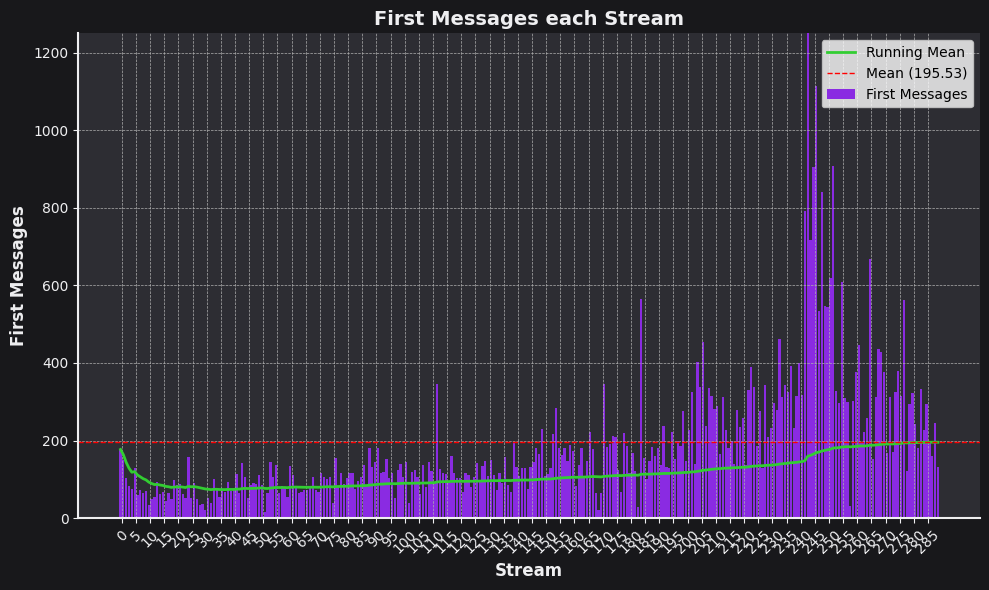

In [11]:
# Plot the chart
fig, ax = plt.subplots(figsize=(10, 6))

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels


# Bar plots
bar1 = ax.bar(index, stream_stats['first_messages'], color='#8A2BE2', edgecolor='none', alpha=1, label='First Messages')

# Plot the running mean line
ax.plot(index, stream_stats['first_messages_avg'], color='#32CD32', linestyle='-', linewidth=2, label='Running Mean')

# Draw the mean line
ax.axhline(mean_first_messages, color='r', linestyle='--', linewidth=1, label=f'Mean ({mean_first_messages:.2f})')

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title
ax.set_xlabel('Stream', fontsize=12, fontweight='bold', color=label_color)
ax.set_ylabel('First Messages', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('First Messages each Stream', fontsize=14, fontweight='bold', color=label_color)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Adjusting x-axis ticks and labels to show every 5th label
xticks = np.arange(0, len(index), 5)
ax.set_xticks([i +1 / 2 for i in xticks])
ax.set_xticklabels(stream_stats.index[xticks], fontsize=10, rotation=45, color=label_color)

# Adding grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Add legend
ax.legend(fontsize=10)

ax.set_ylim(0, 1250)  # Limit the y-axis range to cut off extreme values

plt.tight_layout()
plt.show()


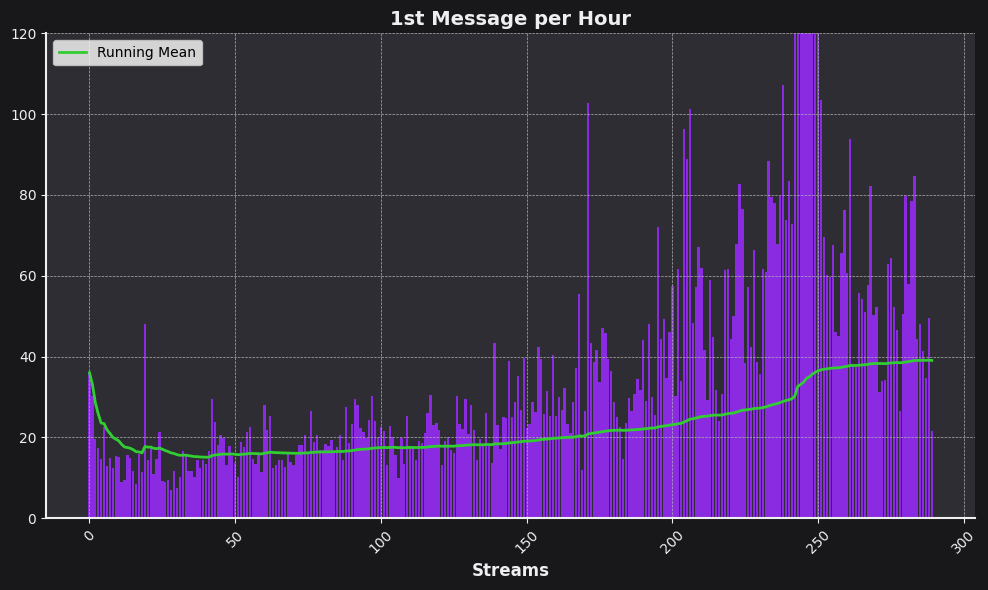

In [12]:
# Plot the chart with custom style
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Bar plot for 'stream_length_per_first' with custom color and transparency
ax.bar(stream_stats.index, 
       stream_stats['stream_length_per_firt'], 
       edgecolor='none',
       color='#8A2BE2',  # Custom color for bars
       alpha=1           # Transparency  
      )
# Adding grid with custom style
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Calculate mean of first messages
mean_stream_length_per_firt = stream_stats['stream_length_per_firt'].expanding().mean()


# Plot the running mean line
ax.plot(stream_stats.index,  # Ensure this is correctly defined
        mean_stream_length_per_firt, 
        color='#32CD32', 
        linestyle='-', 
        linewidth=2, 
        label='Running Mean'
       )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('1st Message per Hour', fontsize=14, fontweight='bold', color=label_color)


# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Add legend
ax.legend()
ax.set_ylim(0, 120)  # Limit the y-axis range to cut off extreme values

plt.tight_layout()
plt.show()


In [13]:
stream_stats['message_count'].head(5)

stream
0    1985
1    3046
2    2754
3    2375
4    2455
Name: message_count, dtype: int64

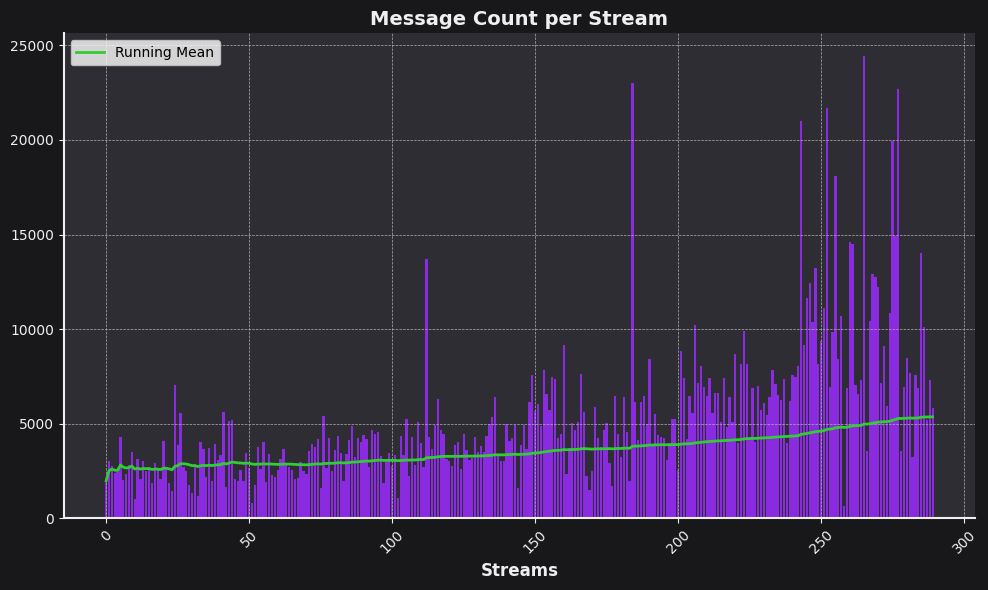

In [14]:
# Plot the chart with custom style
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Bar plot for 'message_count' with custom color and transparency
ax.bar(stream_stats.index, 
       stream_stats['message_count'], 
       edgecolor='none',
       color='#8A2BE2',  # Custom color for bars
       alpha=1           # Transparency  
      )

# Adding grid with custom style
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Calculate running mean for 'message_count'
mean_message_count = stream_stats['message_count'].expanding().mean()

# Plot the running mean line
ax.plot(stream_stats.index,  
        mean_message_count, 
        color='#32CD32', 
        linestyle='-', 
        linewidth=2, 
        label='Running Mean'
       )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('Message Count per Stream', fontsize=14, fontweight='bold', color=label_color)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Add legend
ax.legend()

plt.tight_layout()
plt.show()

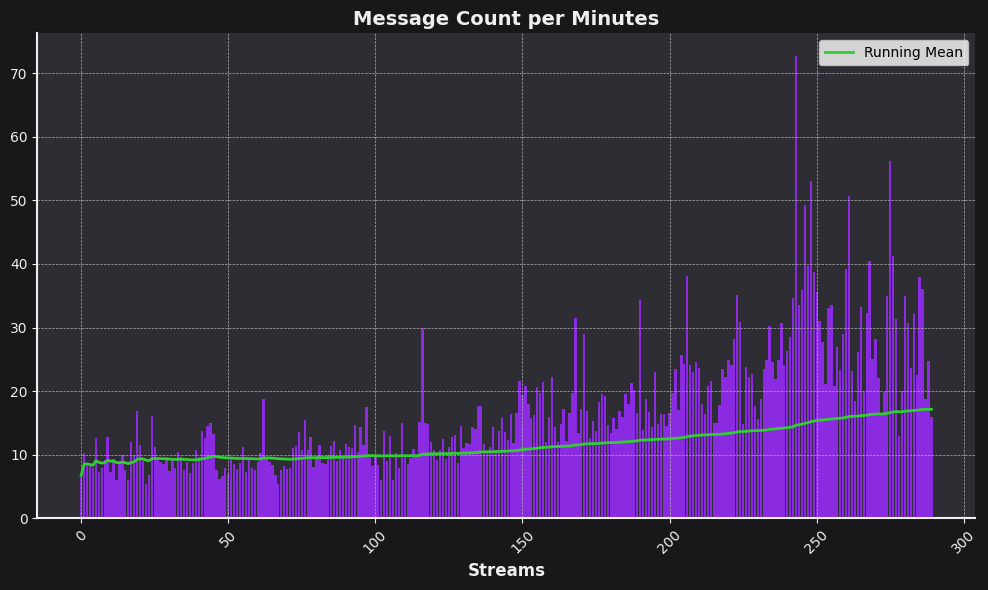

In [15]:
# Plot the chart with custom style
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Bar plot for 'message_per_min' with custom color and transparency
ax.bar(stream_stats.index, 
       stream_stats['message_per_min'], 
       edgecolor='none',
       color='#8A2BE2',  # Custom color for bars
       alpha=1           # Transparency  
      )

# Adding grid with custom style
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Calculate running mean for 'message_count'
mean_message_per_min = stream_stats['message_per_min'].expanding().mean()

# Plot the running mean line
ax.plot(stream_stats.index,  
        mean_message_per_min, 
        color='#32CD32', 
        linestyle='-', 
        linewidth=2, 
        label='Running Mean'
       )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('Message Count per Minutes', fontsize=14, fontweight='bold', color=label_color)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Add legend
ax.legend()

plt.tight_layout()
plt.show()

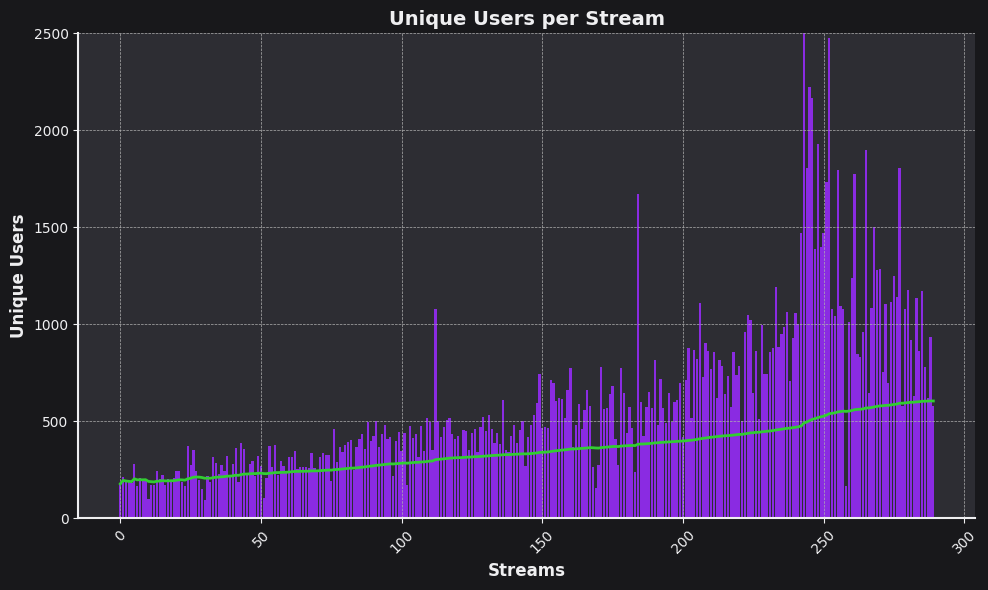

In [16]:
# Plot the chart with custom style
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Bar plot for 'unique_chatters' with custom color and transparency
ax.bar(stream_stats.index, 
       stream_stats['unique_chatters'],
       edgecolor='none', 
       color='#8A2BE2',  # Custom color for bars
       alpha=1           # Transparency  
      )

# Calculate mean of unique chatters
mean_stream_unique = stream_stats['unique_chatters'].expanding().mean()

# Draw the mean line with custom style
ax.plot(mean_stream_unique, 
           color='#32CD32',          # Custom color for mean line
           linestyle='-',           # Line style
           linewidth=2,              # Line width
          )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_ylabel('Unique Users', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('Unique Users per Stream', fontsize=14, fontweight='bold', color=label_color)

# Adding grid with custom style
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

ax.set_ylim(0, 2500)  # Limit the y-axis range to cut off extreme values

plt.tight_layout()
plt.show()


In [17]:
stream_stats['avg_message_user'] = stream_stats["message_count"] / stream_stats["unique_chatters"]

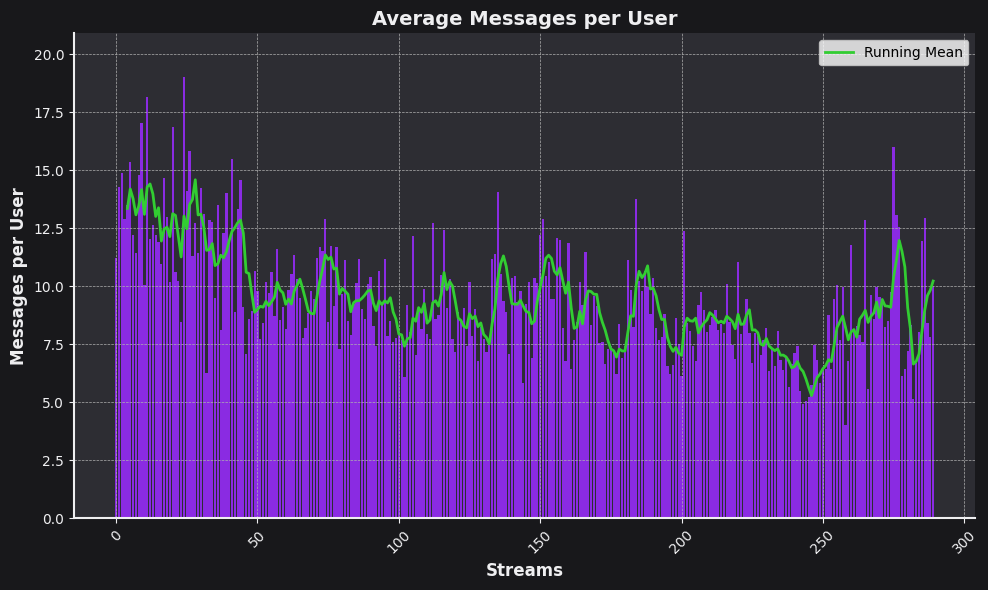

In [18]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels

# Bar plot for 'avg_message_user'
ax.bar(stream_stats.index, 
       stream_stats['avg_message_user'],
       edgecolor='none', 
       color='#8A2BE2',  # Custom color for bars
       alpha=1      # Transparency  
      )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Plot the running mean line
ax.plot(stream_stats.index,  # Ensure this is correctly defined
        stream_stats['avg_message_user'].rolling(window=5).mean(), 
        color='#32CD32', 
        linestyle='-', 
        linewidth=2, 
        label='Running Mean'
       )

# Labels and title
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_ylabel('Messages per User', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('Average Messages per User', fontsize=14, fontweight='bold', color=label_color)

# Adding grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Add legend
ax.legend()

ax.set_ylim(0, stream_stats['avg_message_user'].max() * 1.1)  # Adjust y-axis to fit data

plt.tight_layout()
plt.show()


In [19]:
# Calculate mean of first messages
stream_stats['unique_chatters_per_hour_avg'] = stream_stats['unique_chatters_per_hour'].expanding().mean()

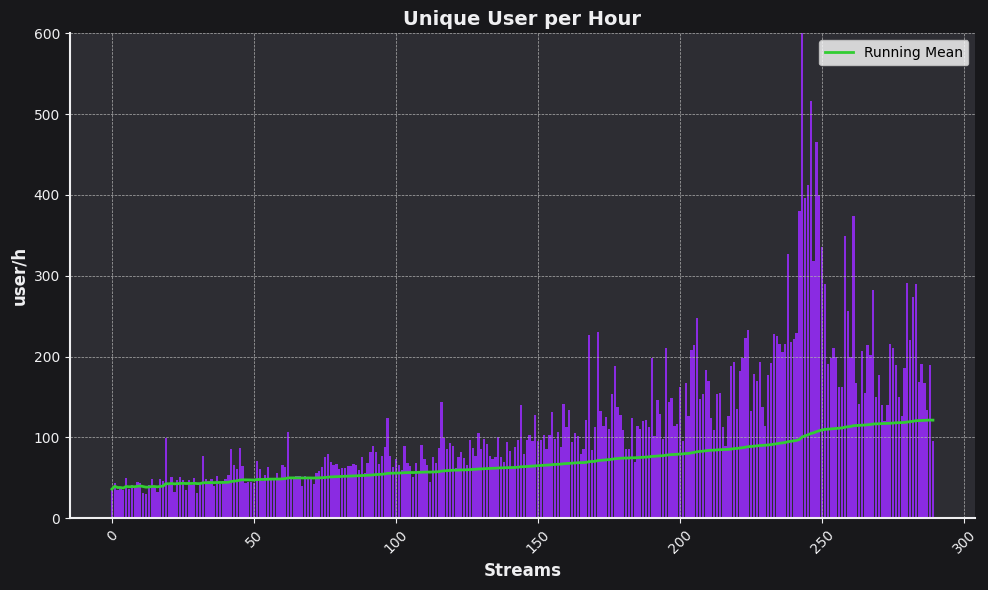

In [20]:

fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels

# Bar plot for 'unique_chatters_per_hour'
ax.bar(stream_stats.index, 
       stream_stats['unique_chatters_per_hour'],
       edgecolor='none', 
       color='#8A2BE2',  # Custom color for bars
       alpha=1      # Transparency  
      )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Plot the running mean line
ax.plot(stream_stats.index,  # Ensure this is correctly defined
        stream_stats['unique_chatters_per_hour_avg'], 
        color='#32CD32', 
        linestyle='-', 
        linewidth=2, 
        label='Running Mean'
       )

# Labels and title
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_ylabel('user/h', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('Unique User per Hour', fontsize=14, fontweight='bold', color=label_color)

# Adding grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Add legend
ax.legend()

ax.set_ylim(0, 600)  # Limit the y-axis range to cut off extreme values

plt.tight_layout()
plt.show()


In [21]:
# Group by stream and aggregate users
stream_users = data.groupby('stream')['user'].apply(set).reset_index()
stream_users.columns = ['stream', 'users']

# Initialize columns for returning users and their count
stream_users['returning_users'] = [set()] * len(stream_users)
stream_users['returning_count'] = 0

# Loop through streams to identify returning users
for i in range(1, len(stream_users)):
    current_users = stream_users.at[i, 'users']
    previous_users = stream_users.at[i - 1, 'users']
    
    # Identify returning users
    returning_users = current_users.intersection(previous_users)
    
    # Update dataframe with returning users and their count
    stream_users.at[i, 'returning_users'] = returning_users
    stream_users.at[i, 'returning_count'] = len(returning_users)

In [22]:
stream_stats = pd.merge(stream_stats, stream_users, on='stream', how='right')

In [23]:
# Calculate mean of first messages
stream_stats['returning_count_avg'] = stream_stats['returning_count'].expanding().mean()

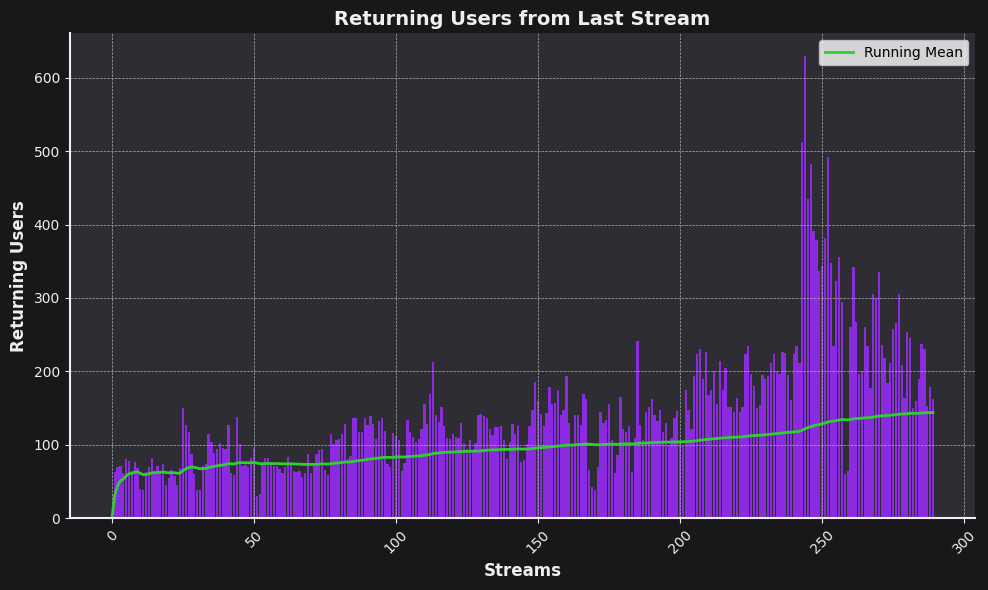

In [24]:
# Plot the chart with custom style
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Bar plot for 'returning_count' with custom color and transparency
ax.bar(stream_stats.index, 
       stream_stats['returning_count'],
       edgecolor='none', 
       color='#8A2BE2',  # Custom color for bars
       alpha=1           # Transparency  
      )

# Plot the running mean line with custom style
ax.plot(stream_stats.index, 
        stream_stats['returning_count_avg'], 
        color='#32CD32',          # Custom color for running mean line
        linestyle='-',           # Line style
        linewidth=2,              # Line width
        label='Running Mean'
       )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_ylabel('Returning Users', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('Returning Users from Last Stream', fontsize=14, fontweight='bold', color=label_color)

# Adding grid with custom style
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Add legend
ax.legend()

plt.tight_layout()
plt.show()


In [25]:
# Create a new column for the first-time chatters by subtracting returning_count from unique_chatters
stream_stats['grouped_return_first'] = stream_stats['returning_count'] + stream_stats['first_messages']

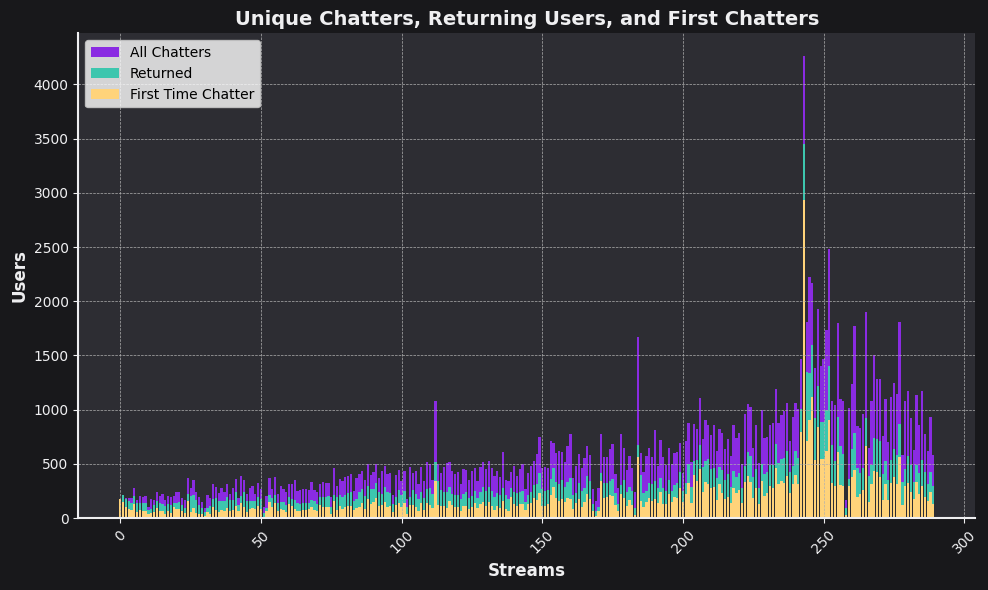

In [26]:
# Plot the bars with specified colors
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Bar plot for all chatters (base layer)
ax.bar(stream_stats.index, 
       stream_stats['unique_chatters'], 
       label='All Chatters',
       edgecolor='none', 
       color='#8A2BE2',  # Custom color for the first set of bars (purple)
       alpha=1           # Transparency
      )

# Bar plot for returning users (stacked on top)
ax.bar(stream_stats.index, 
       stream_stats['grouped_return_first'], 
       label='Returned',
       edgecolor='none', 
       color='#3DC6AE',  # Custom color for the second set of bars
       alpha=1           # Transparency
      )

# Bar plot for first-time chatters (stacked on top)
ax.bar(stream_stats.index, 
       stream_stats['first_messages'], 
       label='First Time Chatter',
       edgecolor='none', 
       color='#FFD37A',  # Custom color for the third set of bars
       alpha=1           # Transparency
      )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_ylabel('Users', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('Unique Chatters, Returning Users, and First Chatters', fontsize=14, fontweight='bold', color=label_color)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Adding legend to differentiate the bars
ax.legend()

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Adding grid with custom style
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()


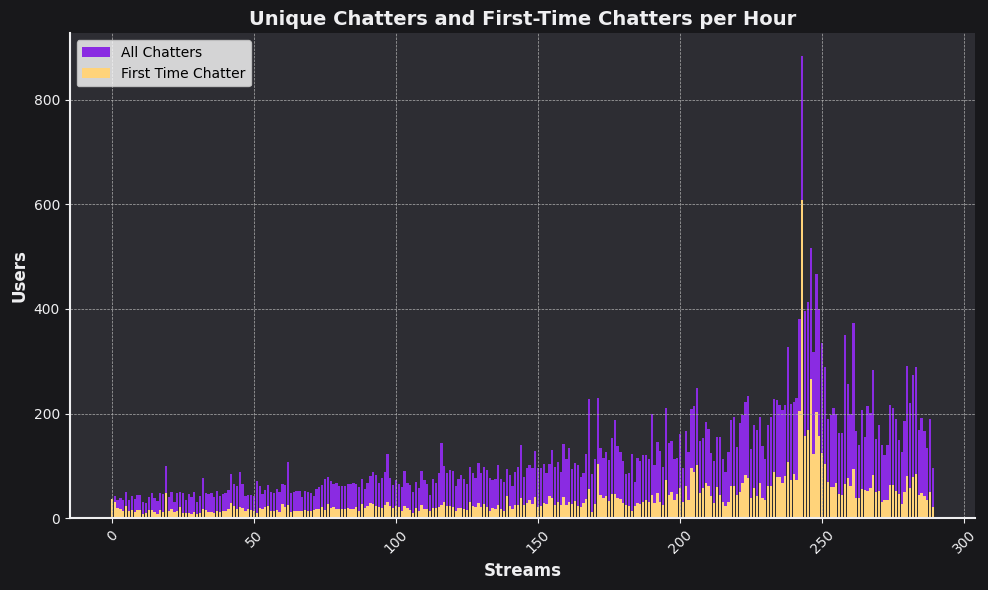

In [27]:
# Plot the bars with specified colors
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Bar plot for all chatters
ax.bar(stream_stats.index, 
       stream_stats['unique_chatters_per_hour'], 
       label='All Chatters',
       edgecolor='none', 
       color='#8A2BE2',  # Custom color for the first set of bars (purple)
       alpha=1           # Transparency
      )

# Bar plot for first-time chatters (stacked on top)
ax.bar(stream_stats.index, 
       stream_stats['stream_length_per_firt'], 
       label='First Time Chatter',
       edgecolor='none', 
       color='#FFD37A',  # Custom color for the second set of bars (yellow)
       alpha=1           # Transparency
      )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_ylabel('Users', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('Unique Chatters and First-Time Chatters per Hour', fontsize=14, fontweight='bold', color=label_color)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Adding legend to differentiate the bars
ax.legend()

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Adding grid with custom style
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()


In [28]:
# Path to your Excel file
file_path = 'DorozeaStreamStats.xlsx'

# Reading a specific sheet with custom column names and skipping the first two rows
exelStats = pd.read_excel(file_path, sheet_name='Munkalap1', header=None, names=['stream', 'avg', 'max','follow','games'], skiprows=1)


In [29]:
stream_stats = pd.merge(stream_stats, exelStats, on='stream', how='right')


In [30]:
#user with only 1 messege

# 1. Group by stream and user, and count the number of messages per user in each stream
user_message_counts = data.groupby(['stream', 'user']).size().reset_index(name='message_count')

# 2. Filter to keep only users who sent exactly one message in a stream
one_message_users = user_message_counts[user_message_counts['message_count'] == 1]

# 3. Count the number of such users for each stream
one_message_user_counts = one_message_users.groupby('stream').size().reset_index(name='one_message_user_count')

# 4. Merge this new information into the stream_stats dataframe
stream_stats = stream_stats.merge(one_message_user_counts, on='stream', how='left')

In [31]:
#2 or more messeges
stream_stats['two_or_more_message_user_counts'] = stream_stats['unique_chatters'] - stream_stats['one_message_user_count']

In [32]:
#message per chater
stream_stats['message_per_chater'] = stream_stats['total_messages'] / stream_stats['unique_chatters']

In [33]:
#hours watched
stream_stats['hours_watched'] = stream_stats['stream_length_hour'] * stream_stats['avg']

In [34]:
#total words count

# 1. Calculate the word count for each message
data['word_count'] = data['message'].apply(lambda x: len(x.split()))

# 2. Sum the word counts for each stream
stream_word_counts = data.groupby('stream')['word_count'].sum().reset_index(name='total_word_count')

# 3. Merge this new information into the stream_stats dataframe
stream_stats = stream_stats.merge(stream_word_counts, on='stream', how='left')

# If there are streams without any messages, fill NaN with 0
stream_stats['total_word_count'] = stream_stats['total_word_count'].fillna(0).astype(int)

In [35]:
stream_stats['avg_words_msg'] = stream_stats['total_word_count'] / stream_stats['total_messages']

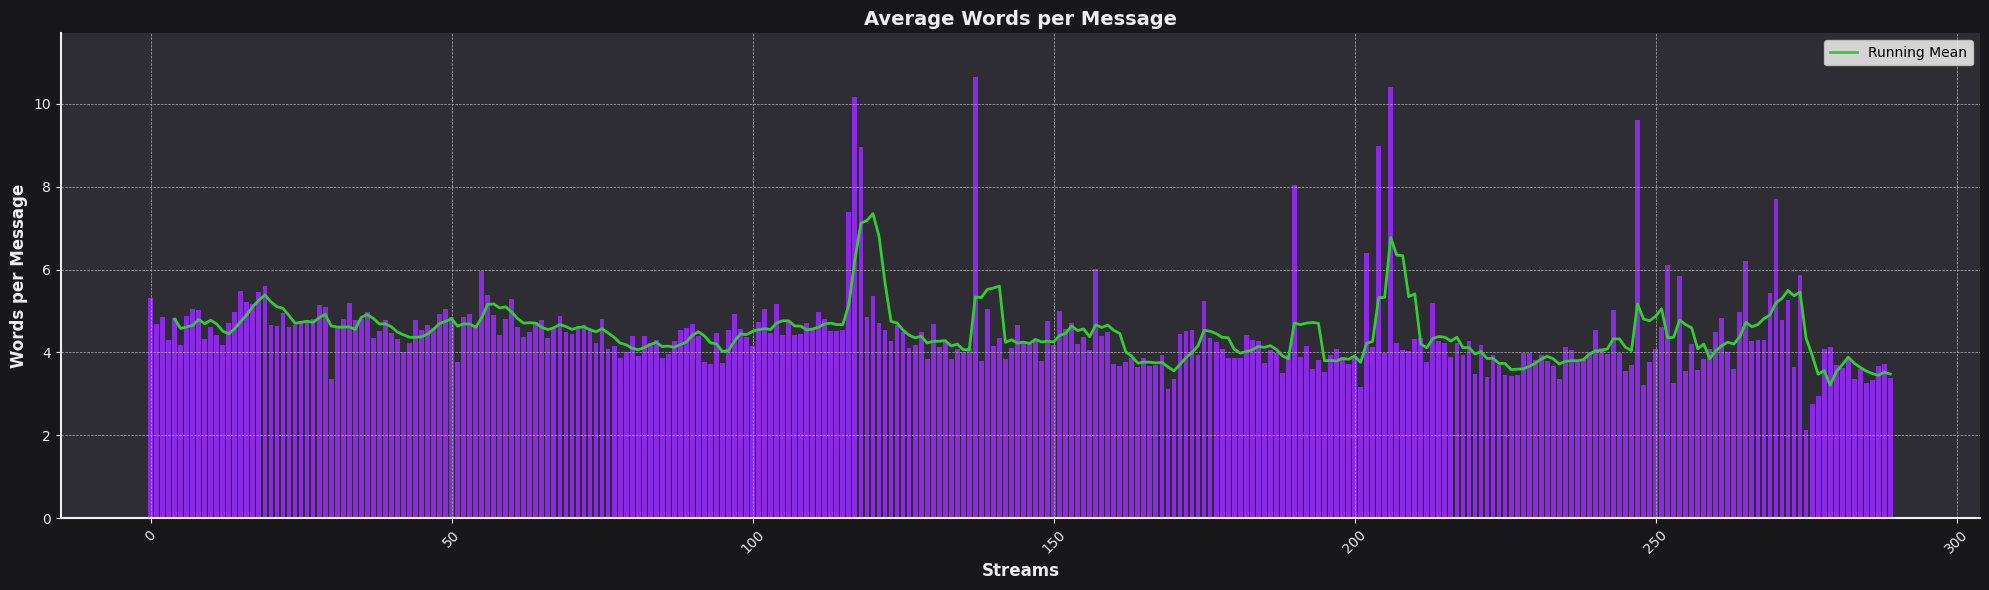

In [36]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(20, 6))  # Set figure size

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels

# Bar plot for 'avg_words_msg'
ax.bar(stream_stats.index, 
       stream_stats['avg_words_msg'],
       edgecolor='none', 
       color='#8A2BE2',  # Custom color for bars
       alpha=1      # Transparency  
      )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Plot the running mean line
ax.plot(stream_stats.index,  
        stream_stats['avg_words_msg'].rolling(window=5).mean(), 
        color='#32CD32', 
        linestyle='-', 
        linewidth=2, 
        label='Running Mean'
       )

# Labels and title
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_ylabel('Words per Message', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('Average Words per Message', fontsize=14, fontweight='bold', color=label_color)

# Adding grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Add legend
ax.legend()

ax.set_ylim(0, stream_stats['avg_words_msg'].max() * 1.1)  # Adjust y-axis to fit data

plt.tight_layout()
plt.show()

In [37]:
#messege/min
stream_stats['message_per_min'] = stream_stats['total_messages'] / stream_stats['stream_length_hour'] / 60


In [38]:
#No stream elements
dataNoBots = data[data['user'] != 'StreamElements']
dataNoBots = dataNoBots[dataNoBots['user'] != 'Fossabot']

In [39]:
# 1. Count the number of messages per user in each stream
user_message_counts = dataNoBots.groupby(['stream', 'user']).size().reset_index(name='message_count')

# 2. Find the top 5 users for each stream - fixed to address the deprecation warning
top_5_users = user_message_counts.groupby('stream').apply(
    lambda x: x.nlargest(5, 'message_count')['user'].tolist(),
    include_groups=False  # Exclude grouping columns
).reset_index(name='top_5_users')

# Convert the list to a comma-separated string for easier viewing
top_5_users['top_5_users'] = top_5_users['top_5_users'].apply(lambda x: ', '.join(x))

# 3. Check if the column already exists in stream_stats and drop it if necessary
if 'top_5_users' in stream_stats.columns:
    stream_stats = stream_stats.drop('top_5_users', axis=1)

# Now merge without conflicts
stream_stats = stream_stats.merge(top_5_users[['stream', 'top_5_users']], on='stream', how='left')

In [40]:
# Display the top 5 users for the last 10 streams without truncation
for index, row in stream_stats.tail(10).iterrows():
    print(f"Stream {index}: {row['top_5_users']}")

Stream 280: rodrigo_20771, Wirelesss_, CrazeE420xd, StunnerGR, JBIN2036
Stream 281: rodrigo_20771, Wirelesss_, banties_x, CrazeE420xd, balintboss
Stream 282: Wirelesss_, CrazeE420xd, schiken44, JBIN2036, balintboss
Stream 283: Wirelesss_, schiken44, balintboss, CrazeE420xd, rodrigo_20771
Stream 284: Hueqi, schiken44, rodrigo_20771, JBIN2036, softarballtt
Stream 285: rodrigo_20771, trek44_, Wirelesss_, schiken44, JBIN2036
Stream 286: Hueqi, rodrigo_20771, banties_x, JBIN2036, schiken44
Stream 287: uuccugr, shogalul, schiken44, balintboss, CrazeE420xd
Stream 288: trek44_, StunnerGR, uuccugr, JBIN2036, CrazeE420xd
Stream 289: StunnerGR, JBIN2036, rodrigo_20771, balintboss, Wirelesss_


In [41]:
#top 5 word in chat


# Define the list of words to exclude
stop_words = {  'the','a','is','to','and','i','you','in','it','u','for',']','so','on',
                'my','are','of','this','they','/','like','have','that','its','?','!','but',
                #maybe not
                'just','was','what','your','can','not','if','she','him','we','they','at','from',
                'by','be','he','do','with','dont','did'
            }

# 1. Tokenize messages by splitting them into words
#data['words'] = data['message'].apply(lambda x: x.split())

# Tokenize messages, splitting into words and filtering out stop words
dataNoBots = dataNoBots.copy()
dataNoBots['words'] = dataNoBots['message'].apply(lambda x: [word for word in x.split() if word.lower() not in stop_words])


# 2. Aggregate all words per stream
stream_words = dataNoBots.groupby('stream')['words'].sum().reset_index()

# 3. Calculate the top 5 most common words for each stream
stream_words['top_5_words'] = stream_words['words'].apply(lambda x: [word for word, count in Counter(x).most_common(5)])

# Convert list to a comma-separated string for easier viewing
stream_words['top_5_words'] = stream_words['top_5_words'].apply(lambda x: ', '.join(x))

# 4. Merge this information into the stream_stats dataframe
stream_stats = stream_stats.merge(stream_words[['stream', 'top_5_words']], on='stream', how='left')

In [42]:
stream_stats['top_5_words'].tail(10)

280                         !play, LUL, o7, 1, gifted
281            ome32, ome44, OMEYES, Banger, Smurfing
282        PartyHat, Happy, Partner, anniversary!, qq
283             !play, Banger, PartyHat, Happy, ome32
284    PepeLaugh, jah, LOL, INZOIPsyCat, dorozeaDance
285                          jah, !play, 󠀀, ome44, om
286                LUL, OMEYES, PepeLaugh, ome44, LOL
287                        hi, LOL, OMEYES, qq, ome44
288                     hi, Banger, LOL, OOOO, OMEYES
289             Headbang, speed2, LOL, 󠀀, INZOIPsyCat
Name: top_5_words, dtype: object

In [43]:
#stream_stats['top_5_words'].to_csv('top_5_words.txt', index=False, header=False)

In [44]:
subData = data[data.apply(lambda row: row['user'].lower() in row['message'].lower(), axis=1)]
subData =  subData[~subData['message'].str.contains(' converted from ', case=False, na=False)]
giftedData = subData[subData['message'].str.contains(' sub ', case=False, na=False)]

unique_gifter = giftedData['user'].nunique()
print("Number of unique Gifter:", unique_gifter)

Number of unique Gifter: 489


In [45]:
giftedData.head(10)

,date,user,message,stream,first_message,word_count
121,2024-05-01 17:14:43+02:00,yusuf2774,yusuf2774 gifted a Tier 1 sub to ChickenBurgah...,0,0,8
567,2024-05-01 18:29:11+02:00,x3lolx,x3lolx gifted a Tier 1 sub to ArtMassong!,0,0,8
569,2024-05-01 18:30:00+02:00,x3lolx,x3lolx gifted a Tier 1 sub to PrachtkerleDE!,0,0,8
576,2024-05-01 18:31:10+02:00,x3lolx,x3lolx gifted a Tier 1 sub to lubb1x!,0,0,8
661,2024-05-01 18:41:16+02:00,x3lolx,x3lolx gifted a Tier 1 sub to alaskalyeska!,0,0,8
1076,2024-05-01 19:54:29+02:00,Bizzan,Bizzan gifted a Tier 1 sub to shotashellz!,0,0,8
1077,2024-05-01 19:54:29+02:00,Bizzan,Bizzan gifted a Tier 1 sub to aabeemick!,0,0,8
1078,2024-05-01 19:54:29+02:00,Bizzan,Bizzan gifted a Tier 1 sub to gantl4!,0,0,8
1079,2024-05-01 19:54:29+02:00,Bizzan,Bizzan gifted a Tier 1 sub to Minaqua__!,0,0,8
1080,2024-05-01 19:54:29+02:00,Bizzan,Bizzan gifted a Tier 1 sub to FeiFuchs!,0,0,8


In [46]:
gifterData = subData[subData['message'].str.contains(' is gifting ', case=False, na=False)].copy()
gifterData['gifts'] = gifterData['message'].apply(lambda x: int(re.search(r'gifting\s(\d+)', x).group(1)))

gift_per_stream_2 = gifterData.groupby('stream')['gifts'].sum()

stream_stats = pd.merge(stream_stats, gift_per_stream_2, on='stream', how='left')

stream_stats = stream_stats.rename(columns={'gifts': 'gift2'})
stream_stats['gift2'] = stream_stats['gift2'].fillna(0)

In [47]:
stream_stats['gift2'].head(5)

0    25.0
1    31.0
2     0.0
3     5.0
4     0.0
Name: gift2, dtype: float64

In [48]:
unique_users_per_stream = giftedData.groupby('stream')['user'].nunique()

stream_stats = pd.merge(stream_stats, unique_users_per_stream, on='stream', how='left')

stream_stats = stream_stats.rename(columns={'user': 'gifter'})
stream_stats['gifter'] = stream_stats['gifter'].fillna(0)

In [49]:
stream_stats['gifter'].describe()

count    290.000000
mean       3.586207
std        3.457275
min        0.000000
25%        1.000000
50%        2.000000
75%        5.000000
max       21.000000
Name: gifter, dtype: float64

In [50]:
gift_per_stream = giftedData.groupby('stream')['user'].count()

stream_stats = pd.merge(stream_stats, gift_per_stream, on='stream', how='left')

stream_stats = stream_stats.rename(columns={'user': 'gift'})
stream_stats['gift'] = stream_stats['gift'].fillna(0)

In [51]:
stream_stats['gift'] = np.maximum(stream_stats['gift'], stream_stats['gift2'])

In [52]:
raids = subData[subData['message'].str.contains(' raiders from ', case=False, na=False)].copy()
raids['raid'] = raids['message'].str.split().str[0]
raids['raid'] = pd.to_numeric(raids['raid'], errors='raise')

raid_stream = raids.groupby('stream')['raid'].max()
stream_stats = pd.merge(stream_stats, raid_stream, on='stream', how='left')
stream_stats['raid'] = stream_stats['raid'].fillna(0)


stream_stats['raid'].head(5)

0      4.0
1    125.0
2      0.0
3      0.0
4      0.0
Name: raid, dtype: float64

In [53]:
stream_stats['raid'].tail(5)

285    130.0
286      0.0
287      0.0
288    335.0
289     22.0
Name: raid, dtype: float64

In [54]:
raids.sort_values(by='stream').tail(5)

,date,user,message,stream,first_message,word_count,raid
1493055,2025-04-01 18:59:30+02:00,Trizze,86 raiders from Trizze have joined!,281,0,6,86
1514035,2025-04-06 15:48:58+02:00,chexyiee,130 raiders from chexyiee have joined!,285,0,6,130
1544241,2025-04-09 17:14:20+02:00,AmirNovaa,50 raiders from AmirNovaa have joined!,288,1,6,50
1541579,2025-04-09 15:26:42+02:00,wabiiisabii,335 raiders from wabiiisabii have joined!,288,0,6,335
1553833,2025-04-11 21:05:48+02:00,1206paul_,22 raiders from 1206paul_ have joined!,289,0,6,22


In [55]:
primeData = subData[subData['message'].str.contains('Prime', case=False, na=False)]

prime_per_stream = primeData.groupby('stream')['user'].count()

stream_stats = pd.merge(stream_stats, prime_per_stream, on='stream', how='left')
stream_stats = stream_stats.rename(columns={'user': 'prime'})
stream_stats['prime'] = stream_stats['prime'].fillna(0)

#stream_stats['prime'].describe()
stream_stats.head(5)


,stream,first_messages,total_messages,unique_chatters,message_count,stream_length,stream_length_hour,stream_length_per_firt,unique_chatters_per_hour,message_per_min,...,hours_watched,total_word_count,avg_words_msg,top_5_users,top_5_words,gift2,gifter,gift,raid,prime
0,0,177,1985,177,1985,17697.0,4.915833,36.006103,36.006103,6.729954,...,634.142500,10568,5.323929,"Martin_Gales, Banties1g, Jello_CS, 1206paul_, ...","1, doro, !play, good, omE",25.0,4.0,25.0,4.0,2.0
1,1,150,3046,213,3046,17831.0,4.953056,30.284336,43.003758,10.249565,...,752.864444,14301,4.695010,"Martin_Gales, saykokerem, klimzaa, LX212, Bant...","sigma, doro, !play, mhm, 1",31.0,4.0,31.0,125.0,1.0
2,2,104,2754,185,2754,19147.0,5.318611,19.553977,34.783517,8.630073,...,670.145000,13389,4.861656,"Banties1g, Martin_Gales, klimzaa, LX212, Wii_Gii","mhm, !play, omE, doro, good",0.0,0.0,0.0,0.0,2.0
3,3,84,2375,184,2375,17451.0,4.847500,17.328520,37.957710,8.165721,...,644.717500,10244,4.313263,"Martin_Gales, Banties1g, LX212, roxa0, zaxkyyy_","!play, mhm, doro, omE, LUL",5.0,2.0,6.0,0.0,1.0
4,4,76,2455,182,2455,18734.0,5.203889,14.604462,34.973844,7.862710,...,770.175556,11883,4.840326,"Martin_Gales, klimzaa, x3lolx, ylb_cat_soul22,...","mhm, doro, good, O?, me",0.0,0.0,0.0,0.0,2.0


In [56]:
trueSub =  subData[~ subData['message'].str.contains('Prime', case=False, na=False)]

trueSub = trueSub[~trueSub['message'].str.contains('raiders', case=False, na=False)]

trueSub = trueSub[~trueSub['message'].str.contains('gifting', case=False, na=False)]

trueSub = trueSub[~trueSub['message'].str.contains('gifted', case=False, na=False)]

trueSub = trueSub[trueSub['message'].str.contains(' subscribed at ', case=False, na=False)]



tier1 = trueSub[trueSub['message'].str.contains('Tier 1', case=False, na=False)]
tier2 = trueSub[trueSub['message'].str.contains('Tier 2', case=False, na=False)]
tier3 = trueSub[trueSub['message'].str.contains('Tier 3', case=False, na=False)]

tier1_per_stream = tier1.groupby('stream')['user'].count()
stream_stats = pd.merge(stream_stats, tier1_per_stream, on='stream', how='left')
stream_stats = stream_stats.rename(columns={'user': 'tier1'})
stream_stats['tier1'] = stream_stats['tier1'].fillna(0)

tier2_per_stream = tier2.groupby('stream')['user'].count()
stream_stats = pd.merge(stream_stats, tier2_per_stream, on='stream', how='left')
stream_stats = stream_stats.rename(columns={'user': 'tier2'})
stream_stats['tier2'] = stream_stats['tier2'].fillna(0)

tier3_per_stream = tier3.groupby('stream')['user'].count()
stream_stats = pd.merge(stream_stats, tier3_per_stream, on='stream', how='left')
stream_stats = stream_stats.rename(columns={'user': 'tier3'})
stream_stats['tier3'] = stream_stats['tier3'].fillna(0)


In [57]:
no_raid = stream_stats[stream_stats['raid']==0][['stream','avg', 'max']].copy()

In [58]:
no_raid.head(5)

,stream,avg,max
2,2,126,161
3,3,133,169
4,4,148,177
5,5,187,252
6,6,127,157


In [59]:

no_raid['per'] = (no_raid['max'] / no_raid['avg']) *100

correct_per = no_raid['per'].mean

In [60]:
stream_stats['avg_rolling'] = stream_stats['avg'].rolling(window=10).mean()

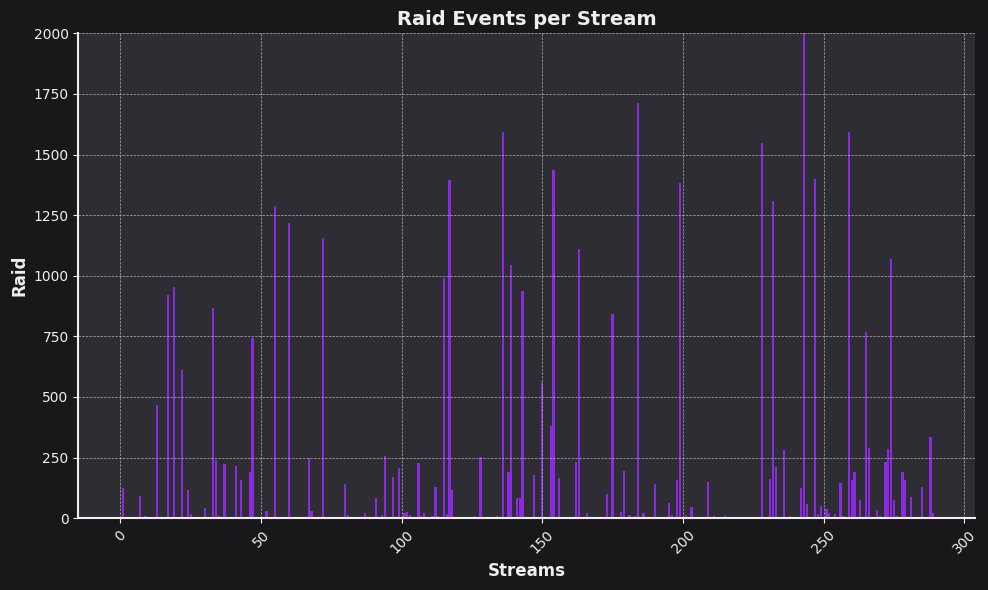

In [61]:
# Plot the bar chart with custom styling
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Bar plot for raid
ax.bar(stream_stats.index, 
       stream_stats['raid'],
       edgecolor='none', 
       color='#8A2BE2',  # Custom color for bars (purple)
       alpha=1           # Transparency
      )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_ylabel('Raid', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('Raid Events per Stream', fontsize=14, fontweight='bold', color=label_color)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10, color=label_color)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Adding grid with custom style
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

ax.set_ylim(0, 2000)  # Limit the y-axis range to cut off extreme values

# Display the plot
plt.tight_layout()
plt.show()


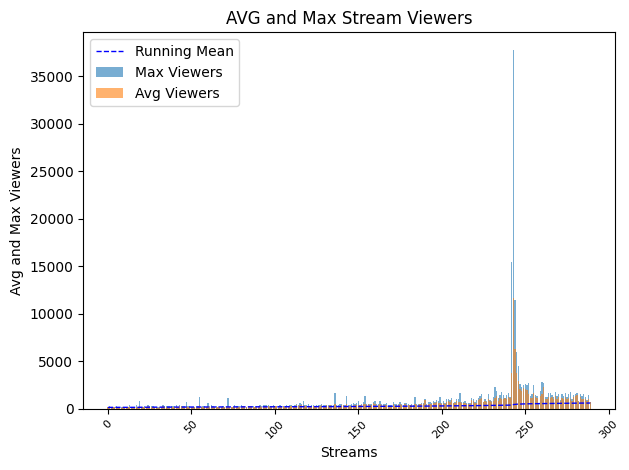

In [62]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for max viewers
ax.bar(stream_stats.index, stream_stats['max'], label='Max Viewers', alpha=0.6, edgecolor='none')

# Bar plot for avg viewers
ax.bar(stream_stats.index, stream_stats['avg'], label='Avg Viewers', alpha=0.6, edgecolor='none')

# Compute expanding average
stream_stats['expanding_avg'] = stream_stats['avg'].expanding().mean()

# Plot the running mean line
ax.plot(stream_stats.index, stream_stats['expanding_avg'], color='b', linestyle='--', linewidth=1, label='Running Mean')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('Avg and Max Viewers', fontsize=10)
ax.set_title('AVG and Max Stream Viewers', fontsize=12)

# Rotate x-axis labels if necessary
plt.xticks(rotation=45, fontsize=8)

# Add legend
ax.legend()

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

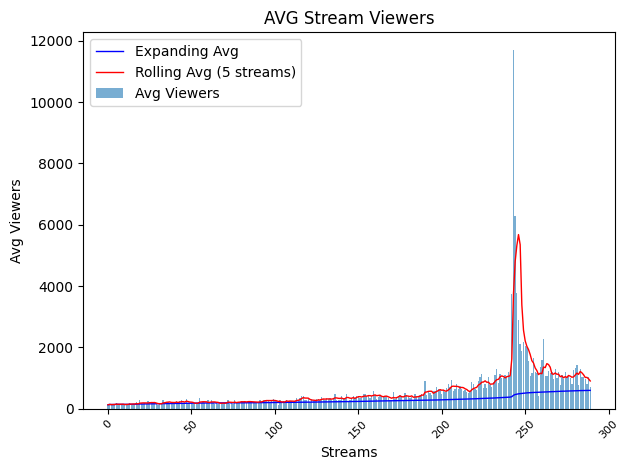

In [63]:
# Compute running averages
stream_stats['expanding_avg'] = stream_stats['avg'].expanding().mean()
stream_stats['avg_rolling'] = stream_stats['avg'].rolling(window=5, min_periods=1).mean()

# Plot the chart
fig, ax = plt.subplots()

# Bar plot for avg viewers
ax.bar(stream_stats.index, stream_stats['avg'], edgecolor='none', alpha=0.6, label='Avg Viewers')

# Plot the running mean line
ax.plot(stream_stats.index, stream_stats['expanding_avg'], color='b', linestyle='-', linewidth=1, label='Expanding Avg')

# Plot the rolling mean line
ax.plot(stream_stats.index, stream_stats['avg_rolling'], color='r', linestyle='-', linewidth=1, label='Rolling Avg (5 streams)')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('Avg Viewers', fontsize=10)
ax.set_title('AVG Stream Viewers', fontsize=12)

# Rotate x-axis labels if necessary
plt.xticks(rotation=45, fontsize=8)

# Add legend
ax.legend()

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

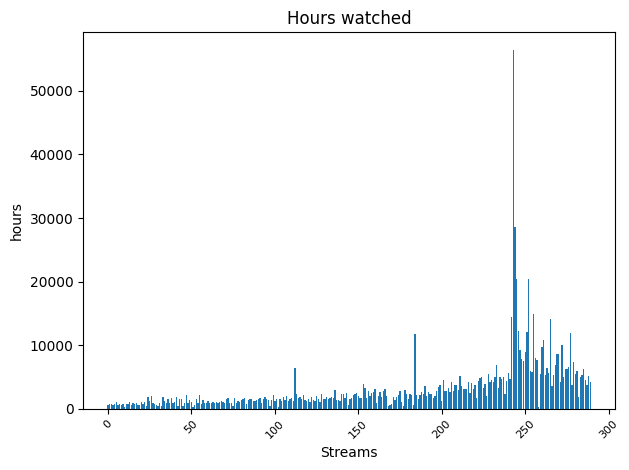

In [64]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for abg viever
ax.bar(stream_stats.index, stream_stats['hours_watched'],edgecolor='none')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('hours', fontsize=10)
ax.set_title('Hours watched', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()

In [65]:
stream_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 40 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   stream                           290 non-null    int64  
 1   first_messages                   290 non-null    int64  
 2   total_messages                   290 non-null    int64  
 3   unique_chatters                  290 non-null    int64  
 4   message_count                    290 non-null    int64  
 5   stream_length                    290 non-null    float64
 6   stream_length_hour               290 non-null    float64
 7   stream_length_per_firt           290 non-null    float64
 8   unique_chatters_per_hour         290 non-null    float64
 9   message_per_min                  290 non-null    float64
 10  first_messages_avg               290 non-null    float64
 11  avg_message_user                 290 non-null    float64
 12  unique_chatters_per_ho

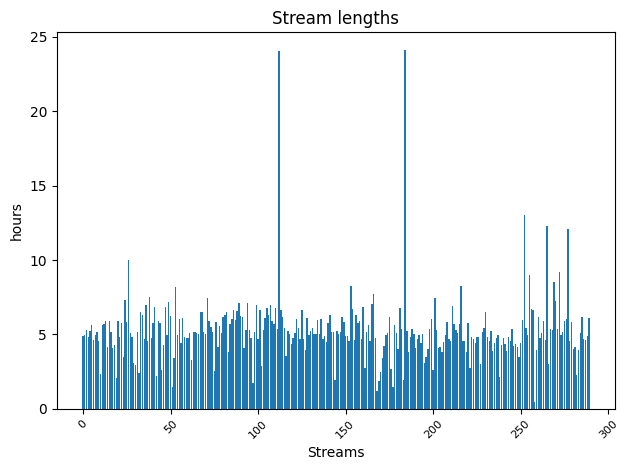

In [66]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for abg viever
ax.bar(stream_stats.index, stream_stats['stream_length_hour'],edgecolor='none')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('hours', fontsize=10)
ax.set_title('Stream lengths', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()

In [67]:

stream_stats.head(2)

,stream,first_messages,total_messages,unique_chatters,message_count,stream_length,stream_length_hour,stream_length_per_firt,unique_chatters_per_hour,message_per_min,...,gift2,gifter,gift,raid,prime,tier1,tier2,tier3,avg_rolling,expanding_avg
0,0,177,1985,177,1985,17697.0,4.915833,36.006103,36.006103,6.729954,...,25.0,4.0,25.0,4.0,2.0,3.0,0.0,0.0,129.0,129.0
1,1,150,3046,213,3046,17831.0,4.953056,30.284336,43.003758,10.249565,...,31.0,4.0,31.0,125.0,1.0,1.0,0.0,0.0,140.5,140.5


In [68]:
stream_stats.tail(2)

,stream,first_messages,total_messages,unique_chatters,message_count,stream_length,stream_length_hour,stream_length_per_firt,unique_chatters_per_hour,message_per_min,...,gift2,gifter,gift,raid,prime,tier1,tier2,tier3,avg_rolling,expanding_avg
288,288,244,7311,934,7311,17692.0,4.914444,49.649559,190.052001,24.794257,...,102.0,4.0,102.0,335.0,15.0,7.0,0.0,0.0,974.4,597.477509
289,289,131,5801,580,5801,21953.0,6.098056,21.482258,95.112285,15.854781,...,2.0,5.0,5.0,22.0,15.0,10.0,0.0,1.0,904.8,597.806897


In [69]:
#stream_stats.to_csv('combined_output.csv', index=False)

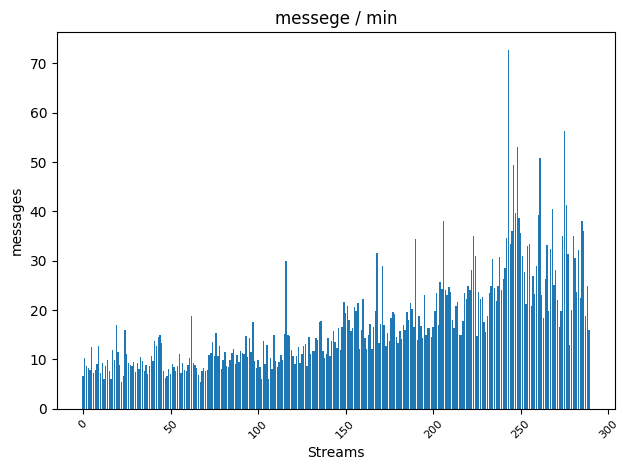

In [70]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for max viever
ax.bar(stream_stats.index, stream_stats['message_per_min'],edgecolor='none')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('messages', fontsize=10)
ax.set_title('messege / min', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()

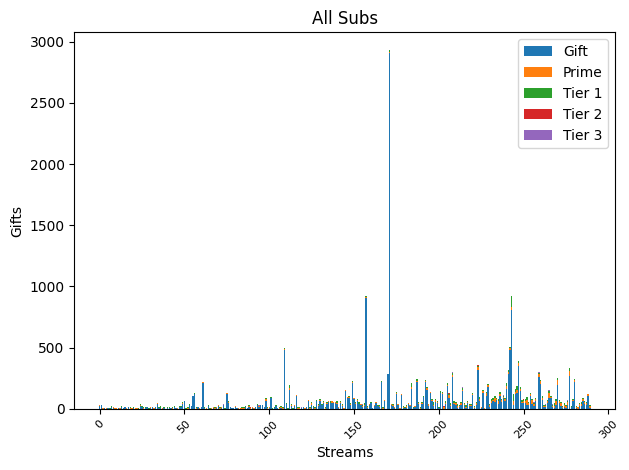

In [71]:
import matplotlib.pyplot as plt

# Plot the chart
fig, ax = plt.subplots()

# Stacked bar plot
ax.bar(stream_stats.index, stream_stats['gift'],edgecolor='none', label='Gift')
ax.bar(stream_stats.index, stream_stats['prime'], bottom=stream_stats['gift'],edgecolor='none', label='Prime')
ax.bar(stream_stats.index, stream_stats['tier1'], bottom=stream_stats['gift'] + stream_stats['prime'],edgecolor='none', label='Tier 1')
ax.bar(stream_stats.index, stream_stats['tier2'], bottom=stream_stats['gift'] + stream_stats['prime'] + stream_stats['tier1'],edgecolor='none', label='Tier 2')
ax.bar(stream_stats.index, stream_stats['tier3'], bottom=stream_stats['gift'] + stream_stats['prime'] + stream_stats['tier1'] + stream_stats['tier2'],edgecolor='none', label='Tier 3')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('Gifts', fontsize=10)
ax.set_title('All Subs', fontsize=12)

# Adding legend to differentiate the bars
ax.legend()

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()


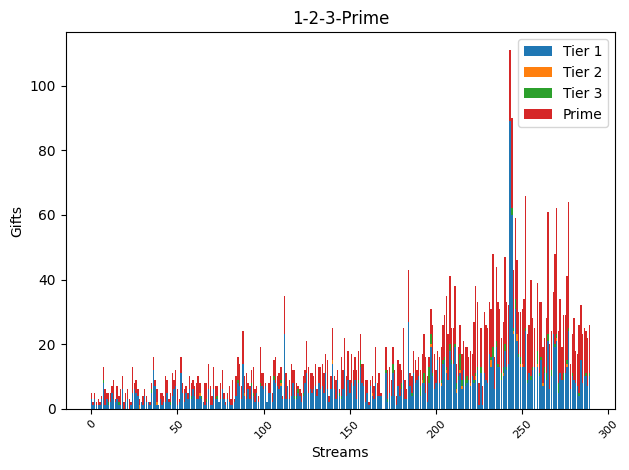

In [72]:
# Plot the chart
fig, ax = plt.subplots()

# Stacked bar plot
ax.bar(stream_stats.index, stream_stats['tier1'],edgecolor='none', label='Tier 1')
ax.bar(stream_stats.index, stream_stats['tier2'], bottom=stream_stats['tier1'],edgecolor='none', label='Tier 2')
ax.bar(stream_stats.index, stream_stats['tier3'], bottom=stream_stats['tier1'] + stream_stats['tier2'],edgecolor='none', label='Tier 3')
ax.bar(stream_stats.index, stream_stats['prime'], bottom=stream_stats['tier1'] + stream_stats['tier2'] + stream_stats['tier3'],edgecolor='none', label='Prime')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('Gifts', fontsize=10)
ax.set_title('1-2-3-Prime', fontsize=12)

# Adding legend to differentiate the bars
ax.legend()

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()


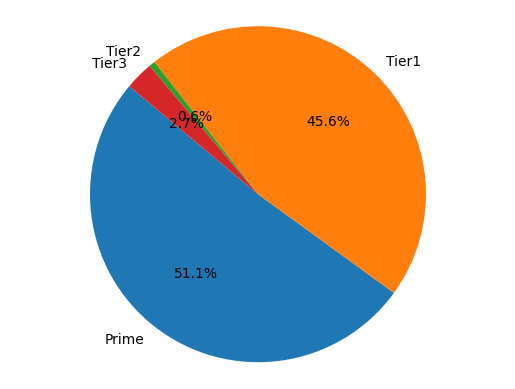

In [73]:
# Data to plot
labels = ['Prime', 'Tier1', 'Tier2', 'Tier3']
sizes = [primeData.shape[0], tier1.shape[0], tier2.shape[0], tier3.shape[0]]

sizes

# Plotting the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')  

# Show the pie chart
plt.show()


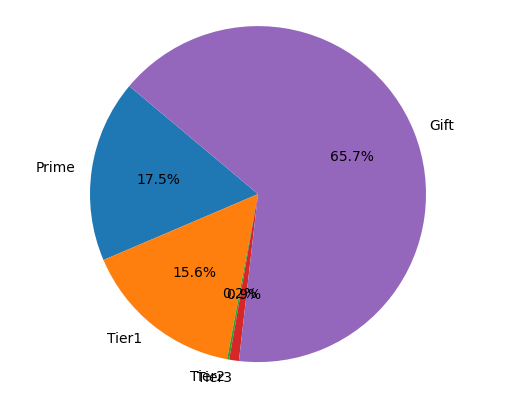

In [74]:
# Data to plot
labels = ['Prime', 'Tier1', 'Tier2', 'Tier3','Gift']
sizes = [primeData.shape[0], tier1.shape[0], tier2.shape[0], tier3.shape[0],giftedData.shape[0]]

sizes

# Plotting the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')  

# Show the pie chart
plt.show()


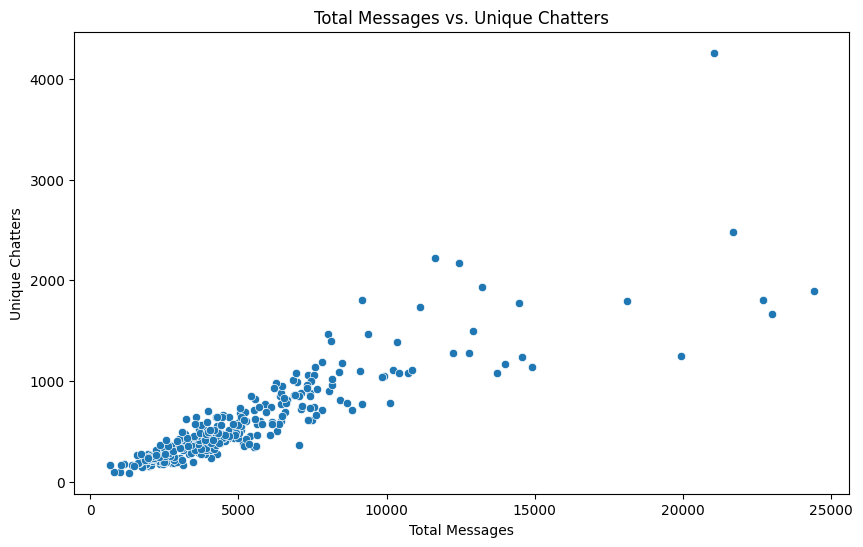

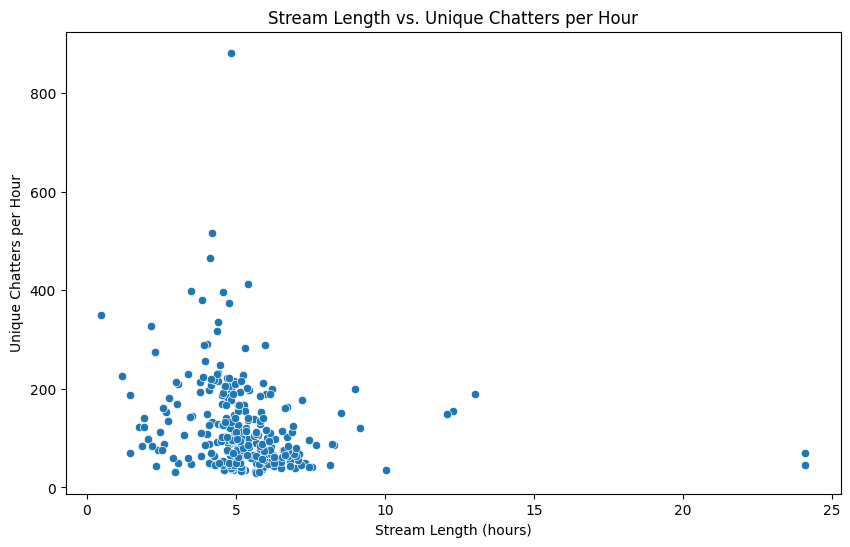

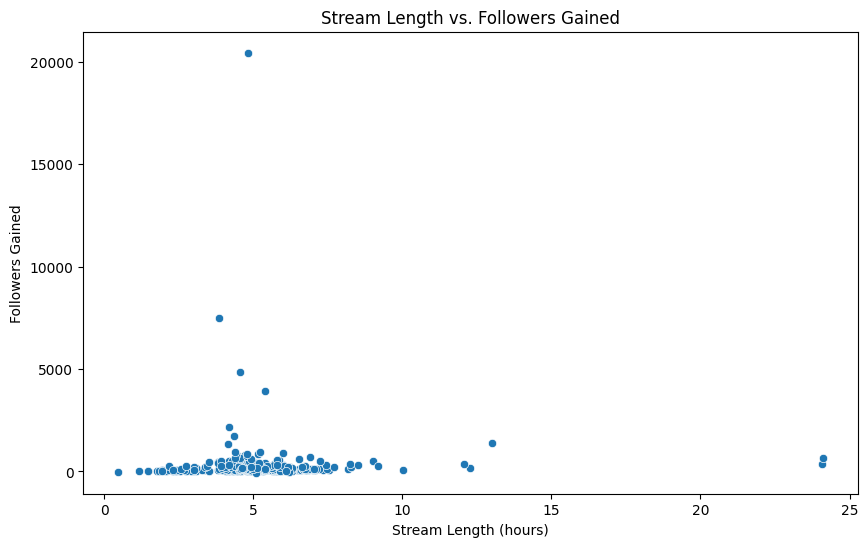

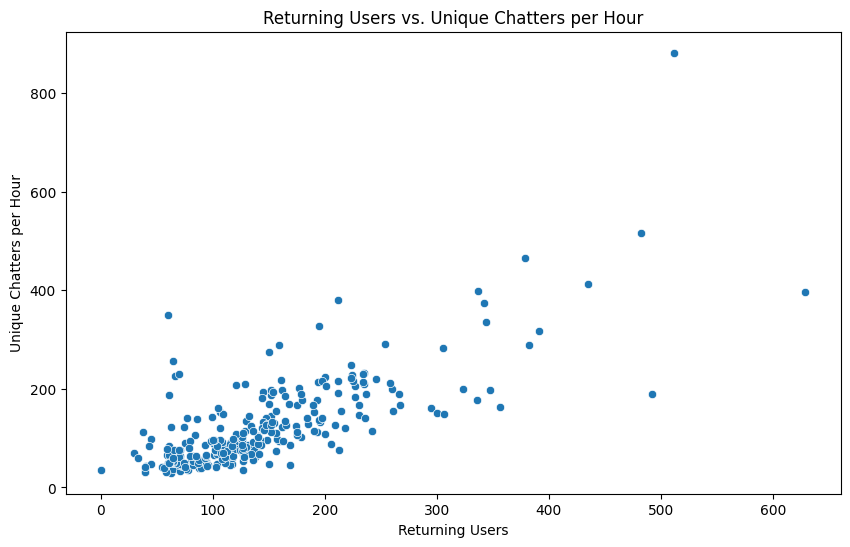

In [75]:

# Scatter plot for Total Messages vs. Unique Chatters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=stream_stats['total_messages'], y=stream_stats['unique_chatters'])
plt.title('Total Messages vs. Unique Chatters')
plt.xlabel('Total Messages')
plt.ylabel('Unique Chatters')
plt.show()

# Scatter plot for Stream Length vs. Unique Chatters per Hour
plt.figure(figsize=(10, 6))
sns.scatterplot(x=stream_stats['stream_length_hour'], y=stream_stats['unique_chatters_per_hour'])
plt.title('Stream Length vs. Unique Chatters per Hour')
plt.xlabel('Stream Length (hours)')
plt.ylabel('Unique Chatters per Hour')
plt.show()

# Scatter plot for Stream Length vs. Followers Gained
plt.figure(figsize=(10, 6))
sns.scatterplot(x=stream_stats['stream_length_hour'], y=stream_stats['follow'])
plt.title('Stream Length vs. Followers Gained')
plt.xlabel('Stream Length (hours)')
plt.ylabel('Followers Gained')
plt.show()

# Scatter plot for Returning Users vs. Unique Chatters per Hour
plt.figure(figsize=(10, 6))
sns.scatterplot(x=stream_stats['returning_count'], y=stream_stats['unique_chatters_per_hour'])
plt.title('Returning Users vs. Unique Chatters per Hour')
plt.xlabel('Returning Users')
plt.ylabel('Unique Chatters per Hour')
plt.show()

In [76]:
# Split the 'games' column into lists
stream_stats['games_list'] = stream_stats['games'].str.split(', ')

# Get the unique games across all streams
unique_games = set(sum(stream_stats['games_list'].tolist(), []))- {''}

# Create a column for each unique game
for game in unique_games:
    stream_stats[game] = stream_stats['games_list'].apply(lambda x: 1 if game in x else 0)

# Drop the temporary 'games_list' column
stream_stats.drop(columns=['games_list'], inplace=True)


In [77]:
stream_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 94 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   stream                           290 non-null    int64  
 1   first_messages                   290 non-null    int64  
 2   total_messages                   290 non-null    int64  
 3   unique_chatters                  290 non-null    int64  
 4   message_count                    290 non-null    int64  
 5   stream_length                    290 non-null    float64
 6   stream_length_hour               290 non-null    float64
 7   stream_length_per_firt           290 non-null    float64
 8   unique_chatters_per_hour         290 non-null    float64
 9   message_per_min                  290 non-null    float64
 10  first_messages_avg               290 non-null    float64
 11  avg_message_user                 290 non-null    float64
 12  unique_chatters_per_ho

In [78]:
unique_games

{'Demonologist',
 'awards',
 'batman',
 'batman2',
 'batman3',
 'carb',
 'chainedtogether',
 'codbo6',
 'cp',
 'crab',
 'cs',
 'deadatnigth',
 'deadlock',
 'demonologist',
 'detroid',
 'elden',
 'er',
 'fnf',
 'fornite',
 'fortnite',
 'garlicshow',
 'irl',
 'jc',
 'lanoire',
 'letalcomp',
 'lol',
 'madison',
 'marbels',
 'marvel',
 'marvels',
 'mc',
 'ow',
 'ow2',
 'parasocial',
 'phazmo',
 'portal2',
 'pubg',
 'r6',
 'rdr1',
 'rdr2',
 're2',
 're3',
 're4',
 're5',
 'repo',
 'roblox',
 'rocket',
 'sh2',
 'special',
 'sus',
 'tMortAss',
 'terraria',
 'tf2',
 'valo'}

In [79]:
#stream_stats.to_csv('combined_output.csv', index=False)

In [80]:
# Define game columns
game_columns = unique_games

# Initialize a dictionary to hold aggregated data
game_impact_data = {}

# Aggregate metrics for each game
for game in game_columns:
    # Filter the dataset for streams where the specific game was played
    game_data = stream_stats[stream_stats[game] == 1]
    
    # Calculate average metrics for the filtered data
    average_metrics = {
        'Average Total Messages': game_data['total_messages'].mean(),
        'Average Unique Chatters': game_data['unique_chatters'].mean(),
        'Average Hours Watched': game_data['hours_watched'].mean(),
        'Average Total Word Count': game_data['total_word_count'].mean(),
        'Average Returning User Count': game_data['returning_count_avg'].mean(),
        'Average Viewer Count': game_data['avg'].mean(),
        'Max Viewer Count': game_data['max'].mean()
    }
    
    # Store the averages in the dictionary
    game_impact_data[game] = average_metrics

# Convert the dictionary to a DataFrame for better visualization
game_impact_df = pd.DataFrame(game_impact_data).T
game_impact_df.reset_index(inplace=True)
game_impact_df.columns = ['Game', 'Average Total Messages', 'Average Unique Chatters', 
                          'Average Hours Watched', 'Average Total Word Count', 
                          'Average Returning User Count','Average Viewer Count',
                          'Max Viewer Count']



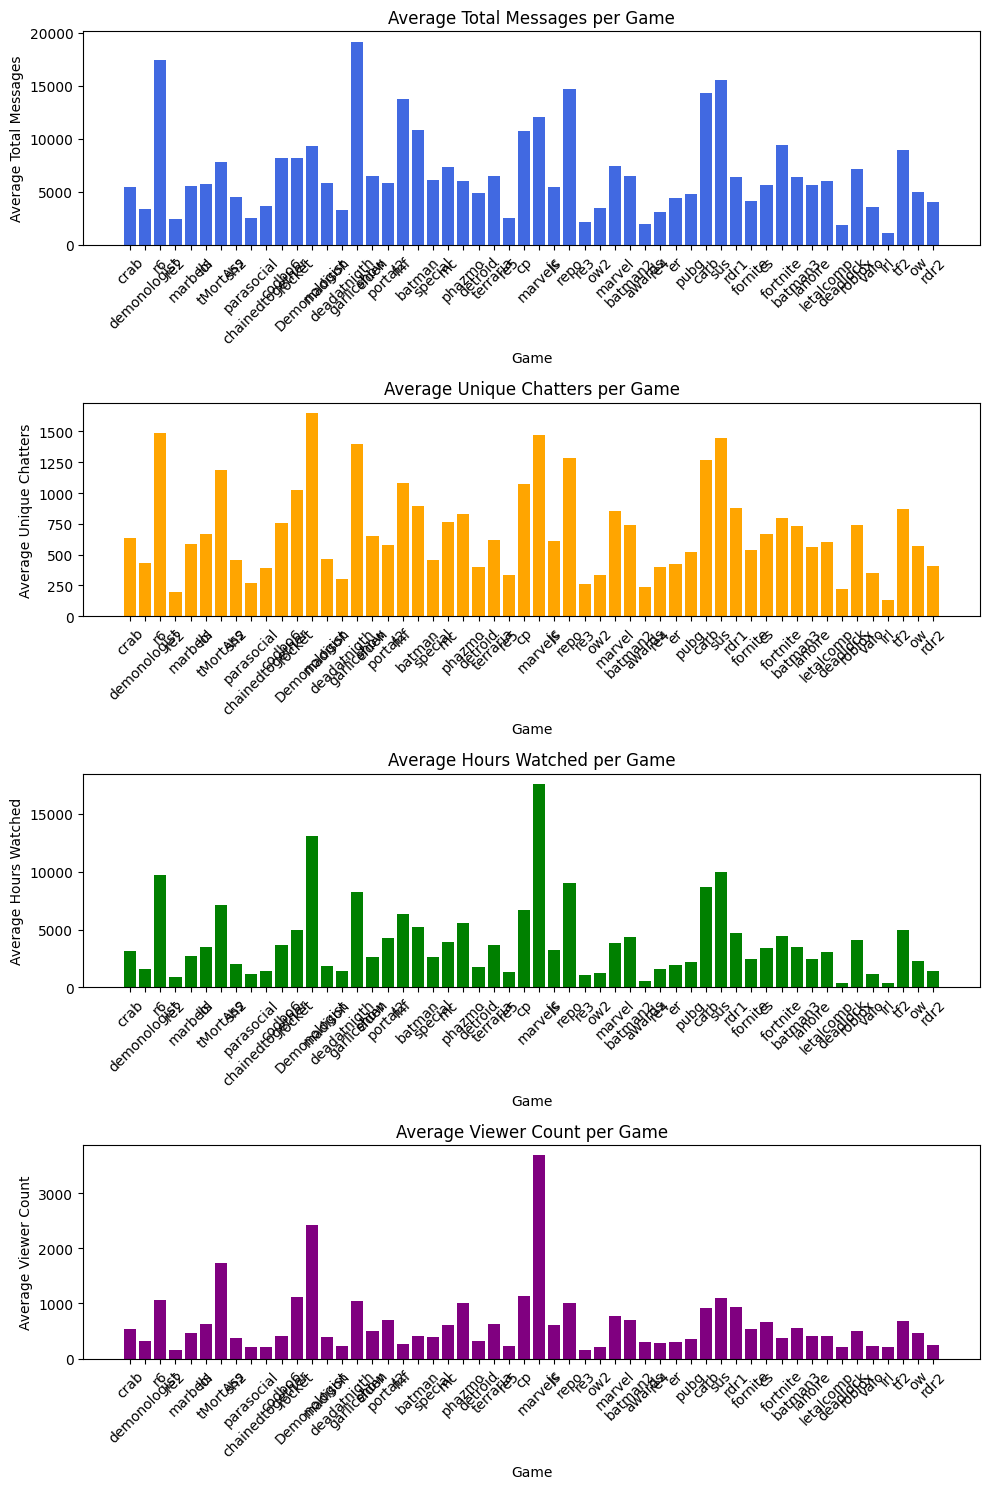

In [81]:
# Set up the figure and axes for subplots
fig, ax = plt.subplots(4, 1, figsize=(10, 15))

# Bar chart for Average Total Messages
ax[0].bar(game_impact_df['Game'], game_impact_df['Average Total Messages'], color='royalblue')
ax[0].set_title('Average Total Messages per Game')
ax[0].set_xlabel('Game')
ax[0].set_ylabel('Average Total Messages')
ax[0].tick_params(axis='x', rotation=45)

# Bar chart for Average Unique Chatters
ax[1].bar(game_impact_df['Game'], game_impact_df['Average Unique Chatters'], color='orange')
ax[1].set_title('Average Unique Chatters per Game')
ax[1].set_xlabel('Game')
ax[1].set_ylabel('Average Unique Chatters')
ax[1].tick_params(axis='x', rotation=45)

# Bar chart for Average Hours Watched
ax[2].bar(game_impact_df['Game'], game_impact_df['Average Hours Watched'], color='green')
ax[2].set_title('Average Hours Watched per Game')
ax[2].set_xlabel('Game')
ax[2].set_ylabel('Average Hours Watched')
ax[2].tick_params(axis='x', rotation=45)

# Bar chart for Average Hours Watched
ax[3].bar(game_impact_df['Game'], game_impact_df['Average Viewer Count'], color='purple')
ax[3].set_title('Average Viewer Count per Game')
ax[3].set_xlabel('Game')
ax[3].set_ylabel('Average Viewer Count')
ax[3].tick_params(axis='x', rotation=45)


# Adjust layout
plt.tight_layout()
plt.show()


In [82]:
# Extract only the date (without time)
data['date_only'] = data['date'].dt.date

# Group by 'stream' and find the first message date
stream_date = data.groupby('stream')['date_only'].min().reset_index()

# Rename the columns appropriately
stream_date.columns = ['stream', 'stream_date']

# Assuming stream_stats is the existing DataFrame you want to update
# Merge the stream_date with the stream_stats DataFrame
stream_stats = stream_stats.merge(stream_date, on='stream', how='left')

# Now, stream_stats will have a new column 'stream_date' with the date of the first message for each stream.


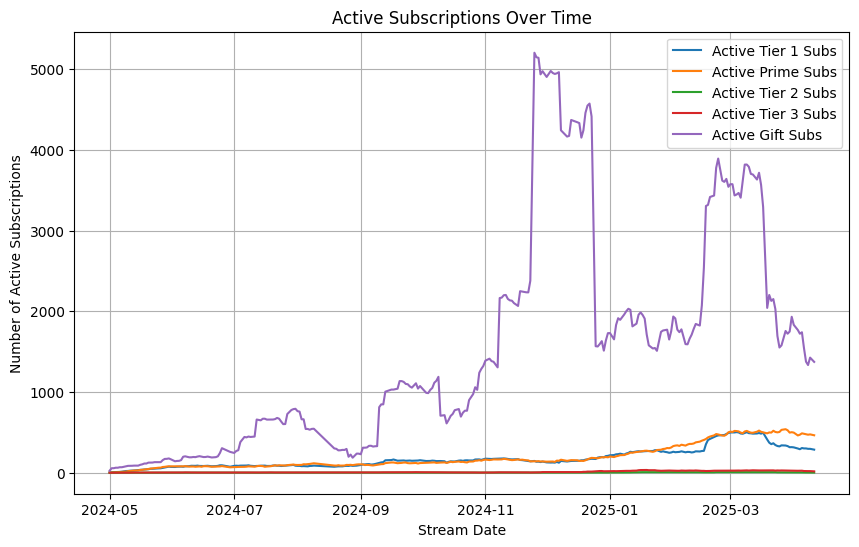

In [83]:
# Convert stream_date to datetime if it is not already
stream_stats['stream_date'] = pd.to_datetime(stream_stats['stream_date'])

# Tier1
active_subs = []

for i in range(len(stream_stats)):
    current_date = stream_stats.iloc[i]['stream_date']
    
    mask = (stream_stats['stream_date'] <= current_date) & \
           (stream_stats['stream_date'] > current_date - pd.Timedelta(days=30))
    active_sub_count = stream_stats.loc[mask, 'tier1'].sum()
    
    active_subs.append(active_sub_count)
stream_stats['active_subs'] = active_subs

# PRIME
active_prime = []

for i in range(len(stream_stats)):
    current_date = stream_stats.iloc[i]['stream_date']
    
    mask = (stream_stats['stream_date'] <= current_date) & \
           (stream_stats['stream_date'] > current_date - pd.Timedelta(days=30))
    active_prime_count = stream_stats.loc[mask, 'prime'].sum()
    
    active_prime.append(active_prime_count)
stream_stats['active_prime'] = active_prime

# Tier2
active_tier2 = []

for i in range(len(stream_stats)):
    current_date = stream_stats.iloc[i]['stream_date']
    
    mask = (stream_stats['stream_date'] <= current_date) & \
           (stream_stats['stream_date'] > current_date - pd.Timedelta(days=30))
    active_tier2_count = stream_stats.loc[mask, 'tier2'].sum()
    
    active_tier2.append(active_tier2_count)
stream_stats['active_tier2'] = active_tier2

# Tier3
active_tier3 = []

for i in range(len(stream_stats)):
    current_date = stream_stats.iloc[i]['stream_date']
    
    mask = (stream_stats['stream_date'] <= current_date) & \
           (stream_stats['stream_date'] > current_date - pd.Timedelta(days=30))
    active_tier3_count = stream_stats.loc[mask, 'tier3'].sum()
    
    active_tier3.append(active_tier3_count)
stream_stats['active_tier3'] = active_tier3

# Tier3
active_gift = []

for i in range(len(stream_stats)):
    current_date = stream_stats.iloc[i]['stream_date']
    
    mask = (stream_stats['stream_date'] <= current_date) & \
           (stream_stats['stream_date'] > current_date - pd.Timedelta(days=30))
    active_gift_count = stream_stats.loc[mask, 'gift'].sum()
    
    active_gift.append(active_gift_count)
stream_stats['active_gift'] = active_gift

# Plot the data
plt.figure(figsize=(10, 6))

# Plot each subscription type with labels
plt.plot(stream_stats['stream_date'], stream_stats['active_subs'], label='Active Tier 1 Subs')
plt.plot(stream_stats['stream_date'], stream_stats['active_prime'], label='Active Prime Subs')
plt.plot(stream_stats['stream_date'], stream_stats['active_tier2'], label='Active Tier 2 Subs')
plt.plot(stream_stats['stream_date'], stream_stats['active_tier3'], label='Active Tier 3 Subs')
plt.plot(stream_stats['stream_date'], stream_stats['active_gift'], label='Active Gift Subs')

# Add title and labels
plt.title('Active Subscriptions Over Time')
plt.xlabel('Stream Date')
plt.ylabel('Number of Active Subscriptions')

# Display grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

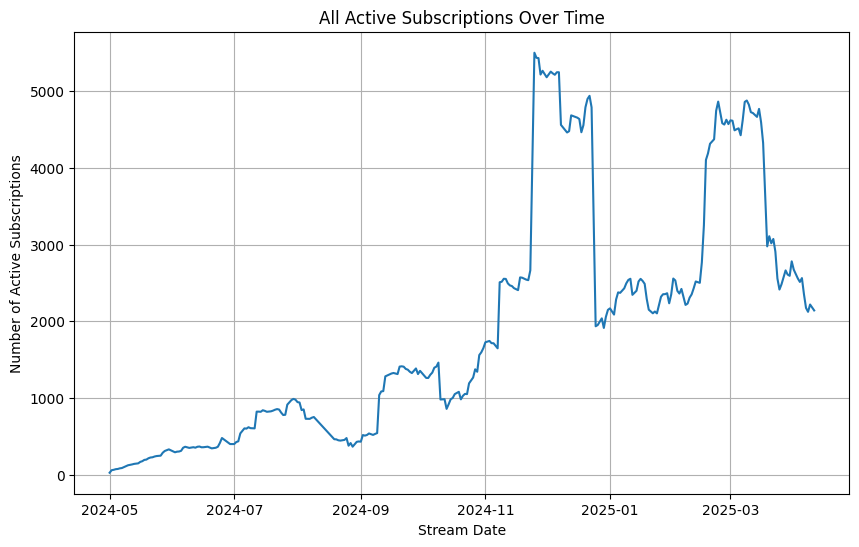

In [84]:
# Calculate the total subs for each stream
stream_stats['all_sub'] = stream_stats['tier1'] + stream_stats['tier2'] + stream_stats['tier3'] + stream_stats['prime'] + stream_stats['gift']

# Initialize a list to store the active subs for each date
active_all_subs = []

# Loop through each date in the dataframe
for i in range(len(stream_stats)):
    current_date = stream_stats.iloc[i]['stream_date']
    
    # Get the total subs in the last 30 days
    mask = (stream_stats['stream_date'] <= current_date) & \
           (stream_stats['stream_date'] > current_date - pd.Timedelta(days=30))
    active_sub_count = stream_stats.loc[mask, 'all_sub'].sum()
    
    active_all_subs.append(active_sub_count)

# Add this new series to the original dataframe
stream_stats['all_active_subs'] = active_all_subs

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(stream_stats['stream_date'], stream_stats['all_active_subs'])
plt.title('All Active Subscriptions Over Time')
plt.xlabel('Stream Date')
plt.ylabel('Number of Active Subscriptions')
plt.grid(True)
plt.show()

In [85]:
stream_stats['ad_rev'] = stream_stats['hours_watched'] * 0.4 / 100

stream_stats['ad_rev']

0       2.536570
1       3.011458
2       2.680580
3       2.578870
4       3.080702
         ...    
285    25.162390
286    18.117000
287    14.695176
288    20.483404
289    16.903810
Name: ad_rev, Length: 290, dtype: float64

In [86]:
stream_stats.tail(3)

,stream,first_messages,total_messages,unique_chatters,message_count,stream_length,stream_length_hour,stream_length_per_firt,unique_chatters_per_hour,message_per_min,...,rdr2,stream_date,active_subs,active_prime,active_tier2,active_tier3,active_gift,all_sub,all_active_subs,ad_rev
287,287,161,5193,618,5193,16657.0,4.626944,34.796182,133.565468,18.705649,...,0,2025-04-08,296.0,471.0,3.0,20.0,1334.0,56.0,2124.0,14.695176
288,288,244,7311,934,7311,17692.0,4.914444,49.649559,190.052001,24.794257,...,0,2025-04-09,296.0,475.0,2.0,20.0,1426.0,124.0,2219.0,20.483404
289,289,131,5801,580,5801,21953.0,6.098056,21.482258,95.112285,15.854781,...,0,2025-04-11,286.0,464.0,2.0,17.0,1373.0,31.0,2142.0,16.903810


In [87]:
#stream_stats.to_csv('combined_output.csv', index=False)

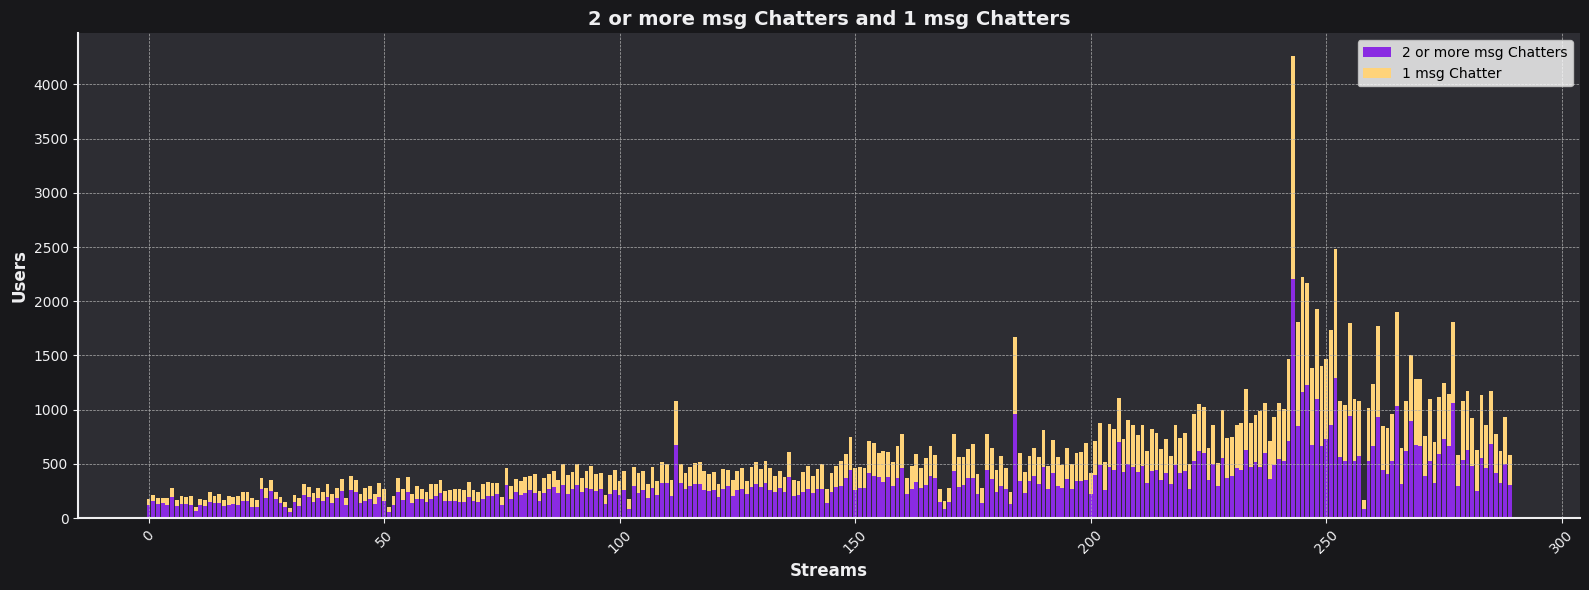

In [88]:
#one_message_user_count
#two_or_more_message_user_counts

# Plot the bars with specified colors
fig, ax = plt.subplots(figsize=(16, 6))  # Set figure size

# Bar plot for all chatters
ax.bar(stream_stats.index, 
       stream_stats['two_or_more_message_user_counts'], 
       label='2 or more msg Chatters',
       edgecolor='none', 
       color='#8A2BE2',  # Custom color for the first set of bars (purple)
      )

# Bar plot for first-time chatters (stacked on top)
ax.bar(stream_stats.index, 
       stream_stats['one_message_user_count'],
       bottom=stream_stats['two_or_more_message_user_counts'],
       label='1 msg Chatter',
       edgecolor='none', 
       color='#FFD37A',  # Custom color for the second set of bars (yellow)
      )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_ylabel('Users', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('2 or more msg Chatters and 1 msg Chatters', fontsize=14, fontweight='bold', color=label_color)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Adding legend to differentiate the bars
ax.legend()

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Adding grid with custom style
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()


In [89]:
stream_stats['2mgs_per'] = stream_stats['two_or_more_message_user_counts'] / (stream_stats['two_or_more_message_user_counts'] + stream_stats['one_message_user_count']) * 100
stream_stats['1mgs_per'] = 100 - stream_stats['2mgs_per']

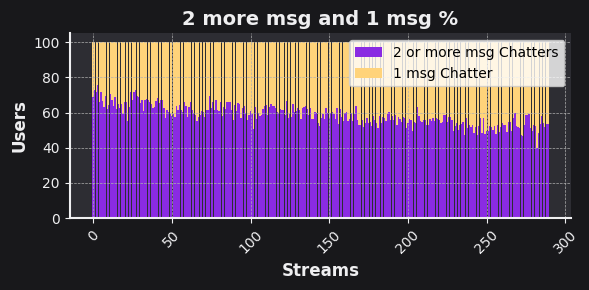

In [90]:
# Plot the bars with specified colors
fig, ax = plt.subplots(figsize=(6, 3))  # Set figure size

# Bar plot for all chatters
ax.bar(stream_stats.index, 
       stream_stats['2mgs_per'], 
       label='2 or more msg Chatters',
       edgecolor='none', 
       color='#8A2BE2',  # Custom color for the first set of bars (purple)
      )

# Bar plot for first-time chatters (stacked on top)
ax.bar(stream_stats.index, 
       stream_stats['1mgs_per'],
       bottom=stream_stats['2mgs_per'],
       label='1 msg Chatter',
       edgecolor='none', 
       color='#FFD37A',  # Custom color for the second set of bars (yellow)
      )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_ylabel('Users', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('2 more msg and 1 msg %', fontsize=14, fontweight='bold', color=label_color)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Adding legend to differentiate the bars
ax.legend()

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Adding grid with custom style
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()


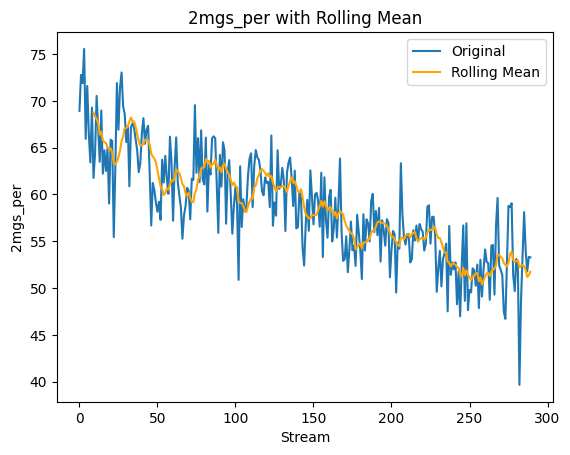

In [91]:
stream_stats['rolling_mean'] = stream_stats['2mgs_per'].rolling(window=10).mean()

plt.plot(stream_stats['stream'], stream_stats['2mgs_per'], label='Original')
plt.plot(stream_stats['stream'], stream_stats['rolling_mean'], label='Rolling Mean', color='orange')
plt.title('2mgs_per with Rolling Mean')
plt.xlabel('Stream')
plt.ylabel('2mgs_per')
plt.legend()
plt.show()


In [92]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Convert stream_date to ordinal dates, handling NaT values
def safe_toordinal(x):
    try:
        return x.toordinal() if pd.notna(x) else np.nan
    except AttributeError:
        return np.nan

# Convert to datetime first, then to ordinal
stream_stats['time_ordinal'] = pd.to_datetime(stream_stats['stream_date'], errors='coerce').apply(safe_toordinal)

# Remove rows with NaN values
clean_data = stream_stats.dropna(subset=['time_ordinal', '2mgs_per'])

# Prepare data for linear regression
X = clean_data['time_ordinal'].values.reshape(-1, 1)
y = clean_data['2mgs_per'].values

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)

# Get the slope
slope = model.coef_[0]

# Interpret the trend
if slope > 0:
    print("The data is trending upwards.")
elif slope < 0:
    print("The data is trending downwards.")
else:
    print("The data is stagnating.")

# Print additional statistics
print(f"Slope: {slope}")
print(f"Intercept: {model.intercept_}")
print(f"R-squared: {model.score(X, y)}")
print(f"Number of data points used: {len(X)}")
print(f"Total number of original data points: {len(stream_stats)}")

The data is trending downwards.
Slope: -0.04532466993928112
Intercept: 33561.75914778033
R-squared: 0.6427537396684233
Number of data points used: 290
Total number of original data points: 290


In [93]:
import pymannkendall as mk

result = mk.original_test(stream_stats['2mgs_per'])
print(result)

Mann_Kendall_Test(trend='decreasing', h=True, p=0.0, z=-15.496238100926366, Tau=-0.6103328958358191, s=-25576.0, var_s=2723822.0, slope=-0.05516357308930931, intercept=66.56429873999002)


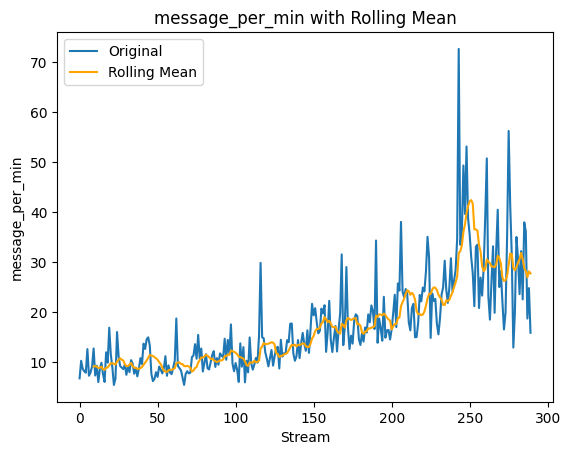

In [94]:
#message_per_min

stream_stats['message_per_min_mean'] = stream_stats['message_per_min'].rolling(window=10).mean()

plt.plot(stream_stats['stream'], stream_stats['message_per_min'], label='Original')
plt.plot(stream_stats['stream'], stream_stats['message_per_min_mean'], label='Rolling Mean', color='orange')
plt.title('message_per_min with Rolling Mean')
plt.xlabel('Stream')
plt.ylabel('message_per_min')
plt.legend()
plt.show()

In [95]:
initial_value = 97068
stream_stats['watch_hour'] = stream_stats['hours_watched'].cumsum() + initial_value

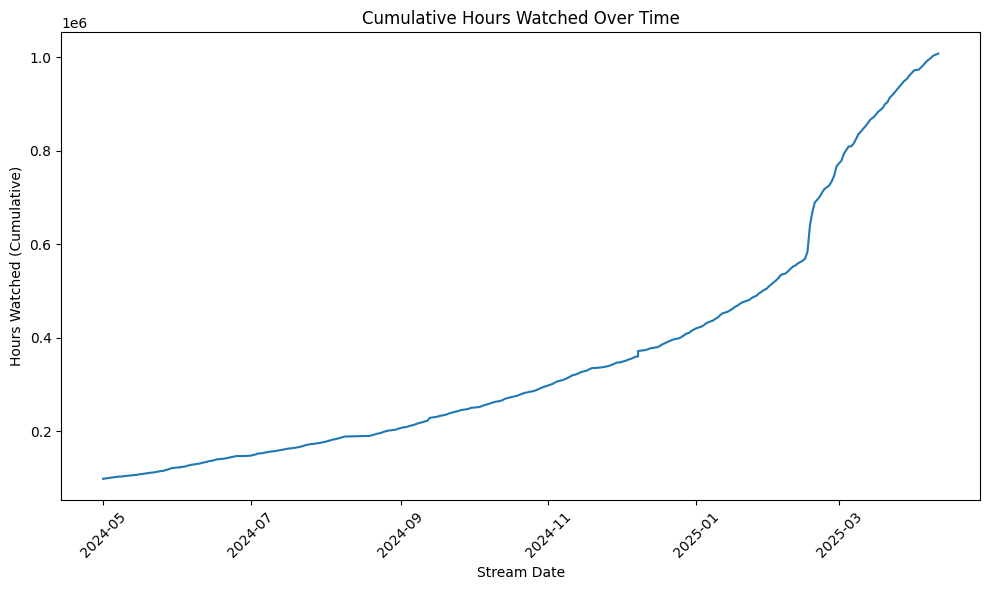

In [96]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(stream_stats['stream_date'], stream_stats['watch_hour'])

# Labels and title
plt.xlabel('Stream Date')
plt.ylabel('Hours Watched (Cumulative)')
plt.title('Cumulative Hours Watched Over Time')

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

In [97]:
stream_stats['watch_hour'].tail(1)

289    1.008261e+06
Name: watch_hour, dtype: float64

In [98]:
stream_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Columns: 109 entries, stream to watch_hour
dtypes: datetime64[ns](1), float64(35), int32(1), int64(67), object(5)
memory usage: 245.9+ KB


In [99]:
stream_stats['1mgs_per'].describe()

count    290.000000
mean      41.357104
std        5.737341
min       24.456522
25%       37.472345
50%       41.406838
75%       45.452706
max       60.350318
Name: 1mgs_per, dtype: float64

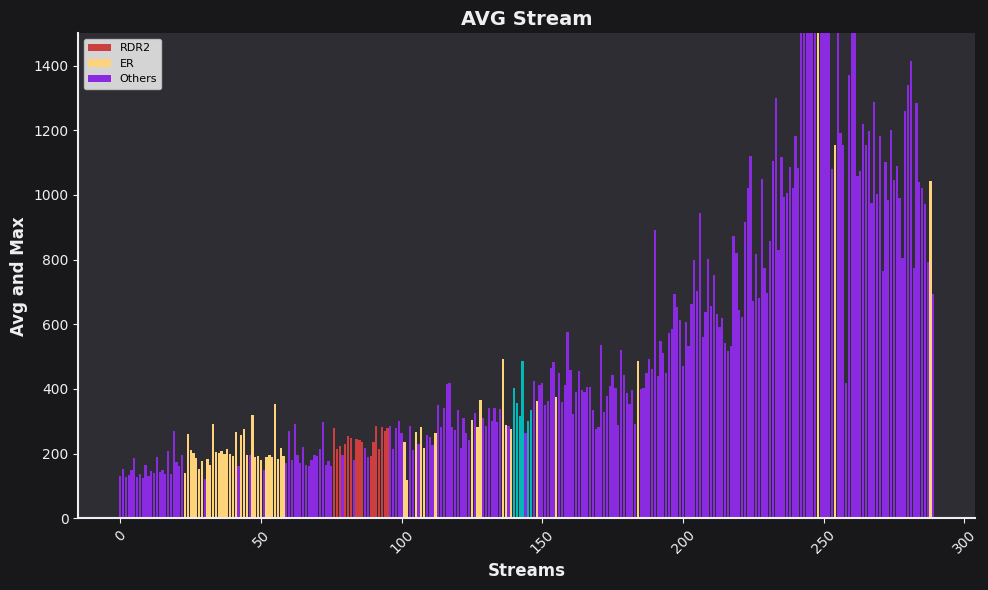

In [100]:
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Create a list of colors based on conditions for each bar
colors = ['#CD3E3E' if sh2 == 1 else '#FFD37A' if rdr2 == 1 else '#00baba' if er == 1 else '#8A2BE2' 
          for sh2,rdr2, er in zip(stream_stats['rdr2'], stream_stats['er'],stream_stats['sh2'])]

# Bar plot with conditional coloring
ax.bar(stream_stats.index, 
       stream_stats['avg'],
       edgecolor='none', 
       color=colors
      )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_ylabel('Avg and Max', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('AVG Stream', fontsize=14, fontweight='bold', color=label_color)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Rotate x labels
plt.xticks(rotation=45, fontsize=10, color=label_color)

# Customize tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Create custom legend to explain color coding
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#CD3E3E', label='RDR2'),     # Red for 'rdr2 == 1'
    Patch(facecolor='#FFD37A', label='ER'),    # Yellow for 'er == 1'
    Patch(facecolor='#8A2BE2', label='Others')  # Purple for the rest
]
ax.legend(handles=legend_elements, fontsize=8, loc='upper left')

ax.set_ylim(0, 1500)  # Limit the y-axis range to cut off extreme values

# Adjust layout and display plot
plt.tight_layout()
plt.show()


In [101]:
start_times = data.groupby('stream')['date'].min().reset_index()
start_times.columns = ['stream', 'start_time']
stream_stats = stream_stats.merge(start_times, on='stream', how='left')
#stream_stats['start_time'] = stream_stats['start_time'].dt.strftime('%H:%M')


In [102]:
stream_stats['start_time'].head(10)

0   2024-05-01 17:04:02+02:00
1   2024-05-02 16:54:47+02:00
2   2024-05-03 17:05:42+02:00
3   2024-05-04 17:06:07+02:00
4   2024-05-05 17:03:35+02:00
5   2024-05-06 16:59:55+02:00
6   2024-05-07 16:58:37+02:00
7   2024-05-09 16:56:43+02:00
8   2024-05-10 17:05:15+02:00
9   2024-05-11 20:31:54+02:00
Name: start_time, dtype: datetime64[ns, Europe/Berlin]

In [103]:
# Extract day of the week and hour
stream_stats['day_of_week'] = stream_stats['start_time'].dt.day_name()  # e.g., 'Monday'
stream_stats['hour'] = stream_stats['start_time'].dt.hour  # 0-23

# Group by day of week and hour, then count the occurrences
heatmap_data = stream_stats.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)

# Reorder the days to start from Monday
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(ordered_days)

In [104]:
# Group by day of week and hour, then count the occurrences
heatmap_data = stream_stats.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)

# Reorder the days to start from Monday
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(ordered_days)

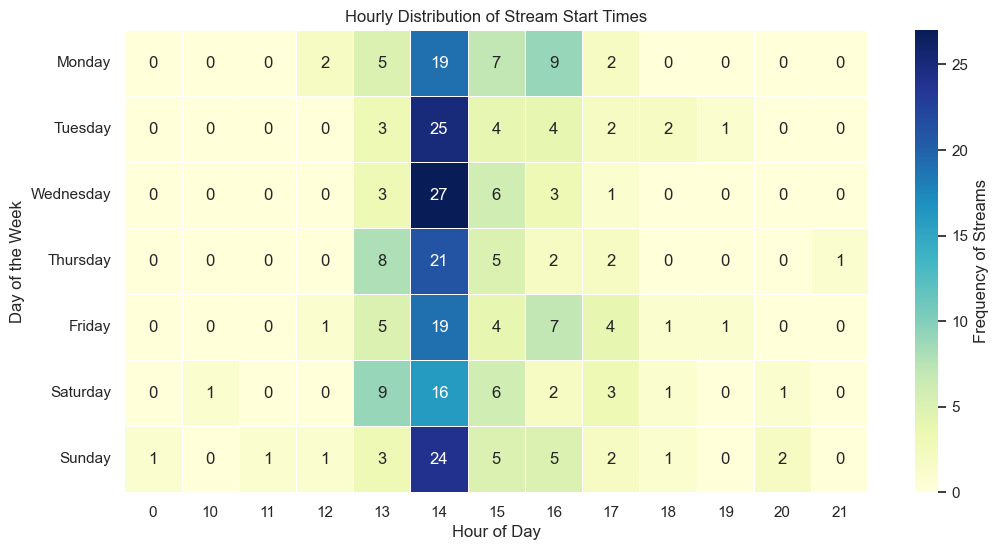

In [105]:
# Set up the figure size and style
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

# Create the heatmap
sns.heatmap(
    heatmap_data, 
    cmap="YlGnBu",   # Color palette (can adjust as needed)
    annot=True,      # Annotate with counts if needed
    fmt="d",         # Format annotations as integers
    linewidths=0.5,  # Line width between cells
    cbar_kws={'label': 'Frequency of Streams'}  # Add color bar label
)

# Add labels and title
plt.xlabel("Hour of Day")
plt.ylabel("Day of the Week")
plt.title("Hourly Distribution of Stream Start Times")
plt.show()

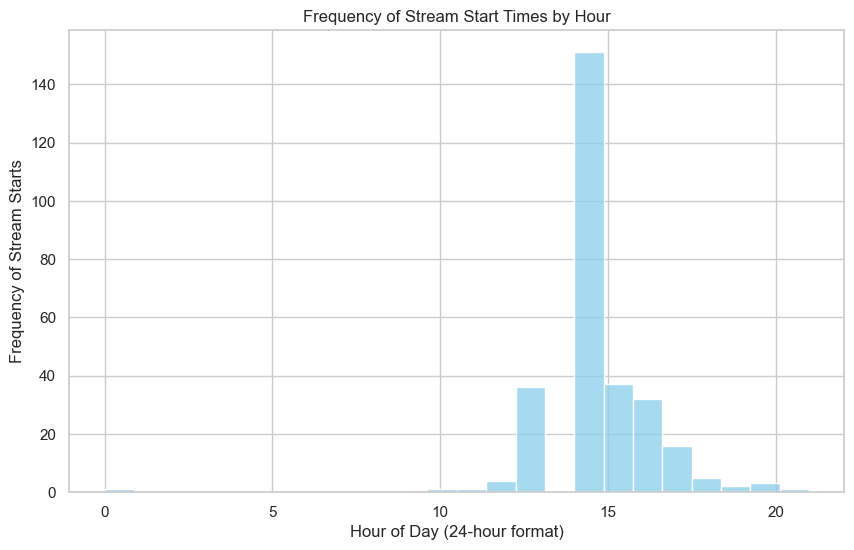

In [106]:
# Set up the figure size
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# Create the histogram
sns.histplot(
    stream_stats['hour'], 
    bins=24,              # One bin for each hour (0–23)
    kde=False,            # Disable the KDE (kernel density estimate) line
    color="skyblue"       # Color of the bars
)

# Customize labels and title
plt.xlabel("Hour of Day (24-hour format)")
plt.ylabel("Frequency of Stream Starts")
plt.title("Frequency of Stream Start Times by Hour")

# Show the plot
plt.show()


In [107]:
# Extract the date and hour for plotting
stream_stats['date'] = stream_stats['start_time'].dt.date
stream_stats['hour'] = stream_stats['start_time'].dt.hour + stream_stats['start_time'].dt.minute / 60  # Convert to decimal hour

In [108]:
stream_stats['hour'].head(2)

0    17.066667
1    16.900000
Name: hour, dtype: float64

In [109]:
# Resample to weekly or monthly average start times
weekly_avg_start = stream_stats.resample('W', on='start_time')['hour'].mean()
monthly_avg_start = stream_stats.resample('ME', on='start_time')['hour'].mean()


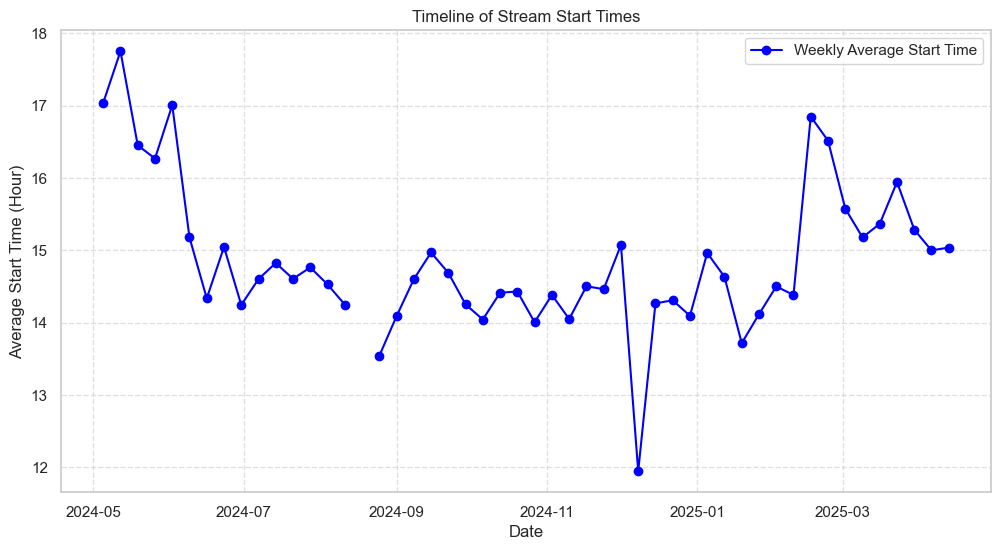

In [110]:
# Set up the figure
plt.figure(figsize=(12, 6))

# Plot the timeline (weekly average in this example)
plt.plot(weekly_avg_start.index, weekly_avg_start, label='Weekly Average Start Time', color='blue', marker='o')

# Customize labels, title, and grid
plt.xlabel("Date")
plt.ylabel("Average Start Time (Hour)")
plt.title("Timeline of Stream Start Times")
plt.grid(True, linestyle='--', alpha=0.6)

# Display the plot
plt.legend()
plt.show()


In [111]:
# Calculate the points for each stream
stream_stats['stream_points'] = (
    stream_stats['tier1'] * 1 +
    stream_stats['tier2'] * 2 +
    stream_stats['tier3'] * 6
)

# Ensure stream_date is datetime
stream_stats['stream_date'] = pd.to_datetime(stream_stats['stream_date'])

# Extract month and year while preserving year transition
stream_stats['month_year'] = stream_stats['stream_date'].dt.to_period('M')

# Group by month and calculate total points
monthly_points = (stream_stats.groupby('month_year')['stream_points']
                 .sum()
                 .reset_index())

# Rename columns
monthly_points.rename(columns={'stream_points': 'total_monthly_points'}, inplace=True)

# Sort by date to ensure chronological order
monthly_points = monthly_points.sort_values('month_year')

print(monthly_points)

   month_year  total_monthly_points
0     2024-05                  95.0
1     2024-06                  88.0
2     2024-07                 124.0
3     2024-08                 121.0
4     2024-09                 193.0
5     2024-10                 181.0
6     2024-11                 180.0
7     2024-12                 326.0
8     2025-01                 434.0
9     2025-02                 640.0
10    2025-03                 495.0
11    2025-04                  97.0


In [112]:
#stream_stats.to_csv('DorozeaStreamStats.csv', index=False)


In [113]:
stream_stats.tail(2)

,stream,first_messages,total_messages,unique_chatters,message_count,stream_length,stream_length_hour,stream_length_per_firt,unique_chatters_per_hour,message_per_min,...,rolling_mean,time_ordinal,message_per_min_mean,watch_hour,start_time,day_of_week,hour,date,stream_points,month_year
288,288,244,7311,934,7311,17692.0,4.914444,49.649559,190.052001,24.794257,...,51.372458,739350,28.153772,1.004035e+06,2025-04-09 15:05:27+02:00,Wednesday,15.083333,2025-04-09,7.0,2025-04
289,289,131,5801,580,5801,21953.0,6.098056,21.482258,95.112285,15.854781,...,51.732422,739352,27.741165,1.008261e+06,2025-04-11 15:03:21+02:00,Friday,15.050000,2025-04-11,16.0,2025-04


In [114]:
max_index = stream_stats['message_per_min'].idxmax()
max_stream = stream_stats.loc[max_index, ['stream', 'stream_date']]

print(max_stream)

stream                         243
stream_date    2025-02-17 00:00:00
Name: 243, dtype: object


In [115]:
min_index = stream_stats['message_per_min'].idxmin()
min_stream = stream_stats.loc[min_index, ['stream', 'stream_date']]

print(min_stream)

stream                          22
stream_date    2024-05-25 00:00:00
Name: 22, dtype: object


In [116]:
# Group by hour and count messages
hourly_counts = data.groupby(data['date'].dt.floor('h')).size()

# Find the hour with the most messages
max_hour = hourly_counts.idxmax()
max_count = hourly_counts.max()

print(f"The hour with the most messages is {max_hour} with {max_count} messages.")

The hour with the most messages is 2025-03-25 18:00:00+01:00 with 10231 messages.


In [117]:
# Get the top 5 hours with the most messages
top_10 = hourly_counts.nlargest(10)

print("Top 5 hours with the most messages:")
print(top_10)

Top 5 hours with the most messages:
date
2025-03-25 18:00:00+01:00    10231
2025-03-26 15:00:00+01:00     8067
2025-02-17 18:00:00+01:00     5330
2025-03-28 20:00:00+01:00     5093
2025-03-25 17:00:00+01:00     5044
2025-02-21 20:00:00+01:00     4569
2025-02-17 20:00:00+01:00     4431
2025-03-09 16:00:00+01:00     4285
2025-03-15 01:00:00+01:00     4230
2025-02-23 17:00:00+01:00     4210
dtype: int64


In [118]:

# Group by 10-minute intervals
grouped = data.resample('10min', on='date').size()

# Get the top 5 intervals with the most messages
top_5 = grouped.sort_values(ascending=False).head(10)

print("Top 5 intervals with the most messages:")
print(top_5)

Top 5 intervals with the most messages:
date
2025-03-25 18:10:00+01:00    2948
2025-03-25 18:00:00+01:00    2927
2025-03-26 15:50:00+01:00    2897
2025-03-25 17:50:00+01:00    2562
2025-03-26 15:40:00+01:00    2416
2025-03-25 18:20:00+01:00    2243
2025-03-28 20:10:00+01:00    2105
2025-02-17 20:20:00+01:00    2039
2025-03-26 15:30:00+01:00    1864
2025-02-23 16:50:00+01:00    1795
dtype: int64


In [119]:
top_5_slowest = stream_stats.nsmallest(5, 'message_per_min')[['stream', 'stream_date', 'message_per_min']]
print(top_5_slowest)

     stream stream_date  message_per_min
22       22  2024-05-25         5.418946
67       67  2024-07-19         5.423077
106     106  2024-09-07         5.933658
12       12  2024-05-15         5.997949
102     102  2024-09-03         6.022945


In [120]:
avg_last_30 = stream_stats.tail(30)['message_per_min'].mean()
print(avg_last_30)

28.979858303740308


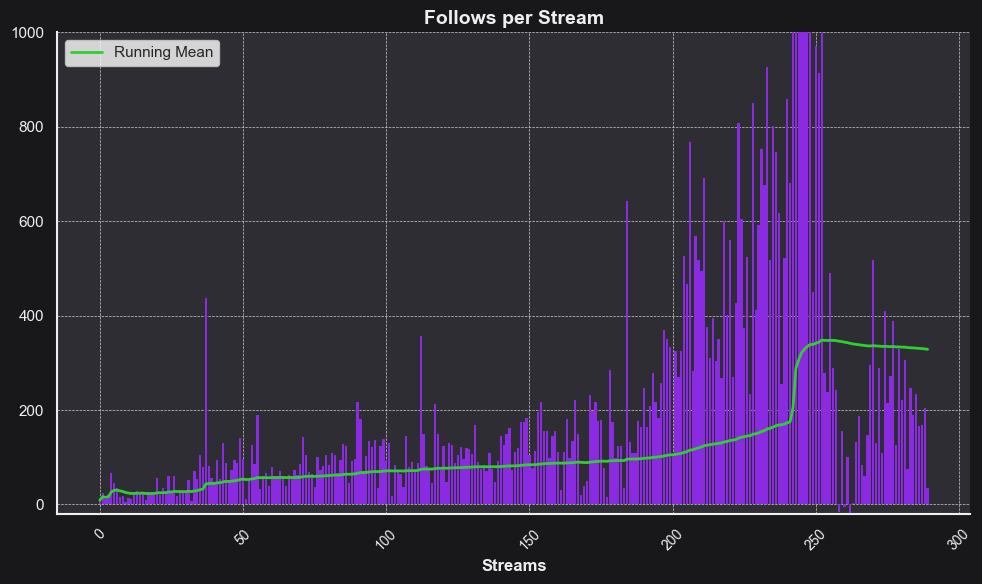

In [121]:
# Plot the chart with custom style
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Bar plot for 'follows' with custom color and transparency
ax.bar(stream_stats.index, 
       stream_stats['follow'], 
       edgecolor='none',
       color='#8A2BE2',  # Custom color for bars
       alpha=1           # Transparency  
      )

# Adding grid with custom style
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Calculate running mean of follows
mean_follows = stream_stats['follow'].expanding().mean()

# Plot the running mean line
ax.plot(stream_stats.index, 
        mean_follows, 
        color='#32CD32', 
        linestyle='-', 
        linewidth=2, 
        label='Running Mean'
       )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('Follows per Stream', fontsize=14, fontweight='bold', color=label_color)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Add legend
ax.legend()
ax.set_ylim(-20, 1000)  # Adjust y-axis limit dynamically

plt.tight_layout()
plt.show()

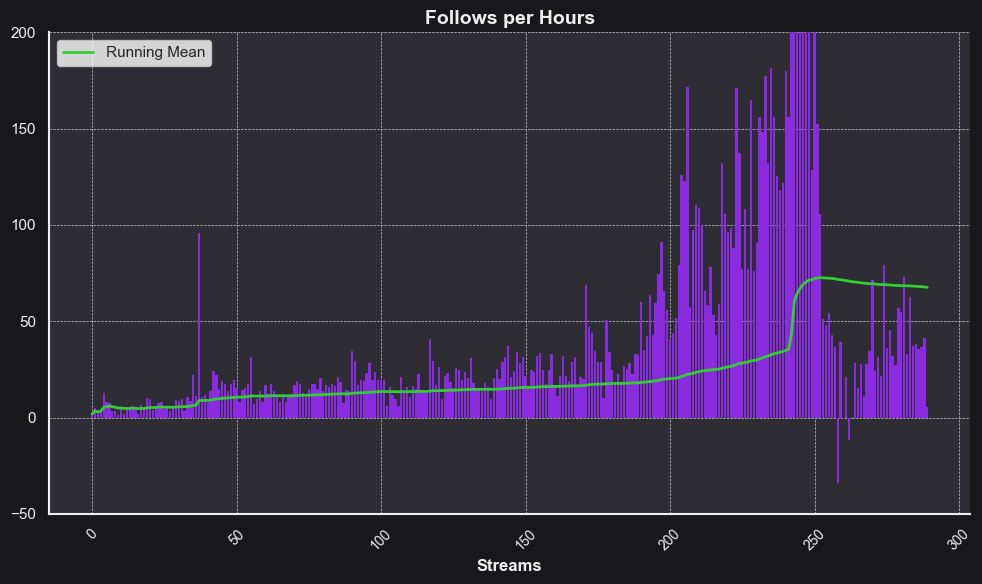

In [122]:
stream_stats['followperhour']=stream_stats['follow']/stream_stats['stream_length_hour']

# Plot the chart with custom style
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Bar plot for 'followperhour' with custom color and transparency
ax.bar(stream_stats.index, 
       stream_stats['followperhour'], 
       edgecolor='none',
       color='#8A2BE2',  # Custom color for bars
       alpha=1           # Transparency  
      )

# Adding grid with custom style
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Calculate running mean of follows
mean_followperhours = stream_stats['followperhour'].expanding().mean()

# Plot the running mean line
ax.plot(stream_stats.index, 
        mean_followperhours, 
        color='#32CD32', 
        linestyle='-', 
        linewidth=2, 
        label='Running Mean'
       )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('Follows per Hours', fontsize=14, fontweight='bold', color=label_color)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Add legend
ax.legend()
ax.set_ylim(-50, 200)  # Adjust y-axis limit dynamically

plt.tight_layout()
plt.show()

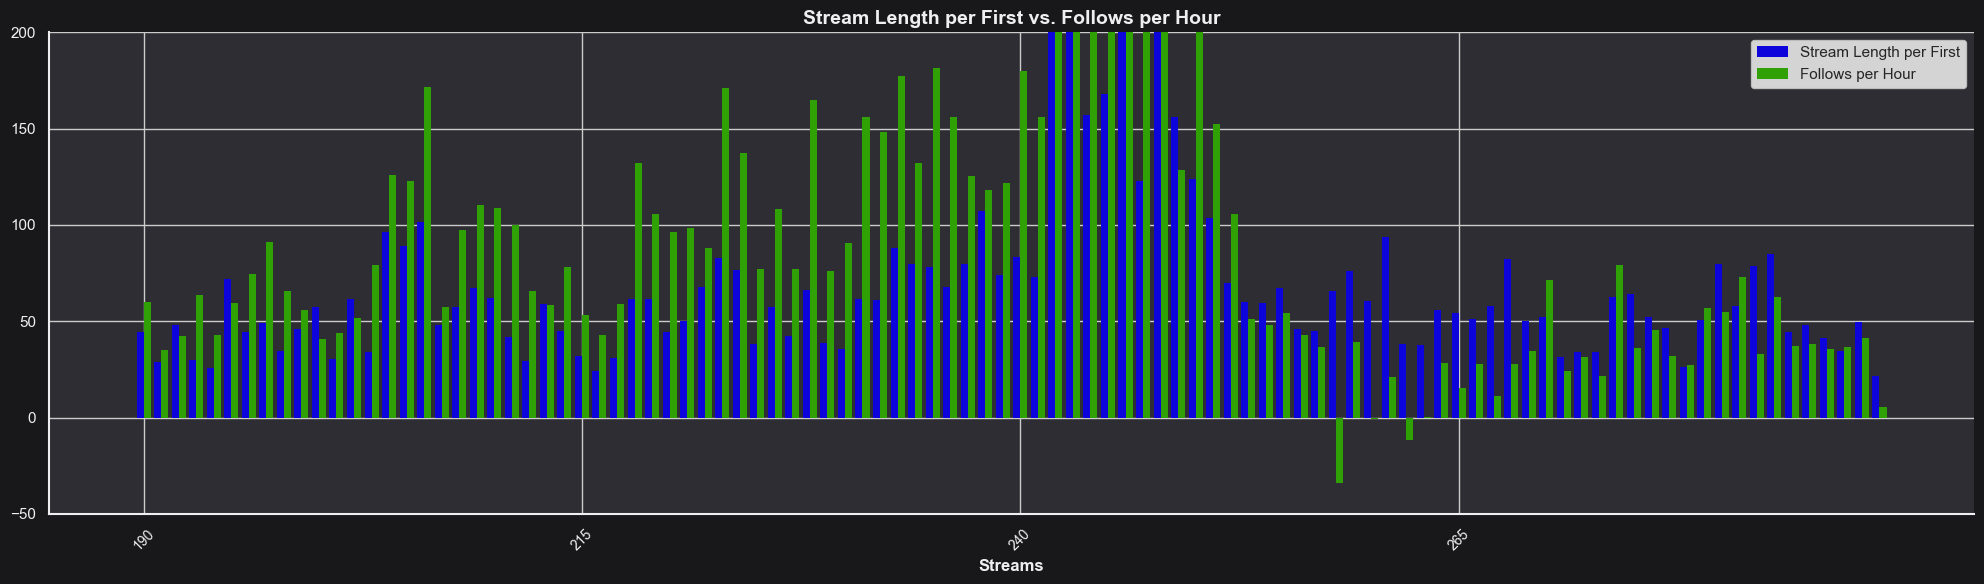

In [123]:
# Define the figure and axis
fig, ax = plt.subplots(figsize=(20, 6))

# Define bar width and positions
bar_width = 0.4
stream_stats_last100 = stream_stats.iloc[-100:]
x = np.arange(len(stream_stats_last100.index))

# Plot bars for 'stream_length_per_firt' (only last 100 rows)
ax.bar(x - bar_width/2, 
       stream_stats_last100['stream_length_per_firt'],  # Fix here
       width=bar_width, 
       color='#0c04db',
       edgecolor='none', 
       label='Stream Length per First')

# Plot bars for 'followperhour' (only last 100 rows)
ax.bar(x + bar_width/2, 
       stream_stats_last100['followperhour'],  # Fix here
       width=bar_width, 
       color='#30a105',
       edgecolor='none', 
       label='Follows per Hour')

# Fix x-ticks to match last 100 rows
plt.xticks(x[::25], stream_stats_last100.index[::25], rotation=45, fontsize=10, color='#EFEFF1')


# Set background color
fig.patch.set_facecolor('#18181B')

# Labels and title
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color='#EFEFF1')
ax.set_title('Stream Length per First vs. Follows per Hour', fontsize=14, fontweight='bold', color='#EFEFF1')

# Customizing axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color('#EFEFF1')
ax.spines['bottom'].set_color('#EFEFF1')

# Tick colors
ax.tick_params(axis='y', colors='#EFEFF1')
ax.tick_params(axis='x', colors='#EFEFF1')
ax.set_ylim(-50, 200)  

# Add legend
ax.legend()

plt.tight_layout()
plt.show()


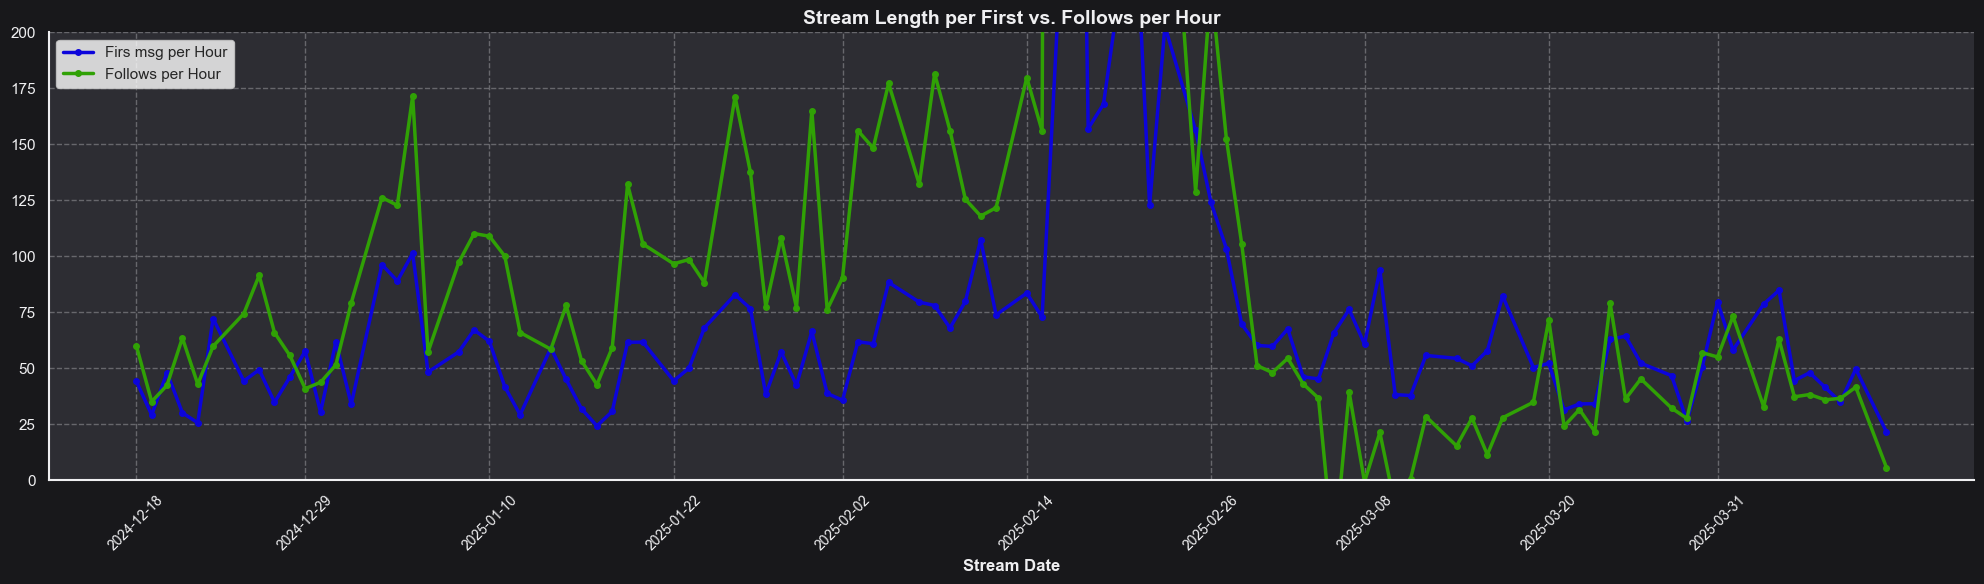

In [124]:
# Define the figure and axis
fig, ax = plt.subplots(figsize=(20, 6))

# Get the last 100 rows of stream_stats
stream_stats_last100 = stream_stats.iloc[-100:]

# Plot lines using dates for x-axis instead of indices
ax.plot(stream_stats_last100['stream_date'], 
       stream_stats_last100['stream_length_per_firt'],
       linewidth=2.5, 
       color='#0c04db',
       marker='o',
       markersize=4,
       label='Firs msg per Hour')

ax.plot(stream_stats_last100['stream_date'], 
       stream_stats_last100['followperhour'],
       linewidth=2.5, 
       color='#30a105',
       marker='o',
       markersize=4,
       label='Follows per Hour')

# Format x-axis with dates - showing every 10th date for readability
date_indices = np.arange(0, len(stream_stats_last100), 10)
plt.xticks([stream_stats_last100['stream_date'].iloc[i] for i in date_indices], 
           [stream_stats_last100['stream_date'].iloc[i] for i in date_indices], 
           rotation=45, 
           fontsize=10, 
           color='#EFEFF1')

# Set background color
fig.patch.set_facecolor('#18181B')

# Labels and title
ax.set_xlabel('Stream Date', fontsize=12, fontweight='bold', color='#EFEFF1')
ax.set_title('Stream Length per First vs. Follows per Hour', fontsize=14, fontweight='bold', color='#EFEFF1')

# Customizing axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color('#EFEFF1')
ax.spines['bottom'].set_color('#EFEFF1')

# Tick colors
ax.tick_params(axis='y', colors='#EFEFF1')
ax.tick_params(axis='x', colors='#EFEFF1')
ax.set_ylim(0, 200)  

# Add grid lines for better readability of the line graph
ax.grid(True, linestyle='--', alpha=0.3, color='#EFEFF1')

# Add legend
ax.legend(loc='upper left', bbox_to_anchor=(0.0, 1.0))

# Format date ticks if they're datetime objects
import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()

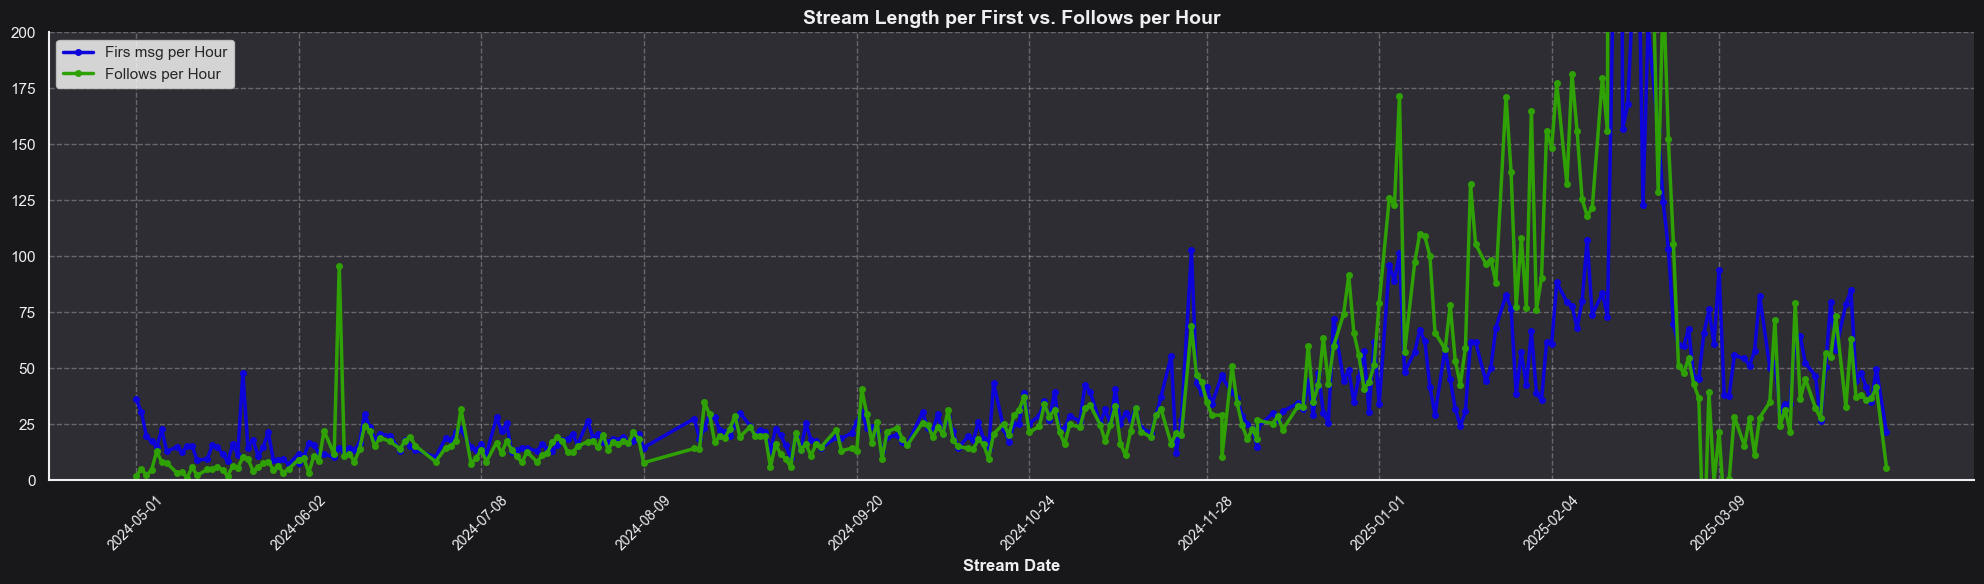

In [125]:
# Define the figure and axis
fig, ax = plt.subplots(figsize=(20, 6))

# Use the entire stream_stats DataFrame instead of just the last 100 rows
# stream_stats_last100 = stream_stats.iloc[-100:]  # Remove or comment out this line

# Plot lines using dates for x-axis for all data
ax.plot(stream_stats['stream_date'], 
       stream_stats['stream_length_per_firt'],
       linewidth=2.5, 
       color='#0c04db',
       marker='o',
       markersize=4,
       label='Firs msg per Hour')

ax.plot(stream_stats['stream_date'], 
       stream_stats['followperhour'],
       linewidth=2.5, 
       color='#30a105',
       marker='o',
       markersize=4,
       label='Follows per Hour')

# Format x-axis with dates - select a reasonable number of tick marks for readability
# Choose intervals based on the total number of data points
num_ticks = 10  # Adjust this number based on how many labels you want on the x-axis
step_size = max(1, len(stream_stats) // num_ticks)
date_indices = np.arange(0, len(stream_stats), step_size)

plt.xticks([stream_stats['stream_date'].iloc[i] for i in date_indices], 
           [stream_stats['stream_date'].iloc[i] for i in date_indices], 
           rotation=45, 
           fontsize=10, 
           color='#EFEFF1')

# Rest of the code remains the same
# Set background color
fig.patch.set_facecolor('#18181B')

# Labels and title
ax.set_xlabel('Stream Date', fontsize=12, fontweight='bold', color='#EFEFF1')
ax.set_title('Stream Length per First vs. Follows per Hour', fontsize=14, fontweight='bold', color='#EFEFF1')

# Customizing axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color('#EFEFF1')
ax.spines['bottom'].set_color('#EFEFF1')

# Tick colors
ax.tick_params(axis='y', colors='#EFEFF1')
ax.tick_params(axis='x', colors='#EFEFF1')

# You might want to adjust the y-limit based on your full dataset values
ax.set_ylim(0, 200)  

# Add grid lines for better readability of the line graph
ax.grid(True, linestyle='--', alpha=0.3, color='#EFEFF1')

# Add legend
ax.legend(loc='upper left', bbox_to_anchor=(0.0, 1.0))

# Format date ticks if they're datetime objects
import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()